# Length of replacement/stable chunks in trees

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
from collections import Counter
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import spacy
from statsmodels.stats.proportion import multinomial_proportions_confint
from progressbar import ProgressBar

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, quantile_interval, get_nlp, token_eq
from analysis.transformations import gaps
from analysis import settings

config = GistsConfiguration.get_solo()
nlp = get_nlp()

## 2 Chunk duration and size

### 2.1 Setup

We need a few helper functions first

In [4]:
def gapless(sequence, idx):
    if token_eq(sequence[idx], settings.ALIGNMENT_GAP_CHAR):
        raise ValueError("index {} is a gap in sequence {}"
                         .format(idx, sequence))
    return idx - int(np.sum([token_eq(el, settings.ALIGNMENT_GAP_CHAR)
                             for el in sequence[:idx]]))

def set_order_array(ids):
    return np.array(list(sorted(set(ids))), dtype=int)


def chunk_indices_with_children(deep_alignments):
    for dal in deep_alignments:
        seq1 = dal['seq1']
        seq2 = dal['seq2']
        subalignments = dal['subalignments']
        
        # Compute this level's app/dis/apprpl/disrpl/stb ids
        base_app_ids = []
        base_dis_ids = []
        base_rpl_pairs = []
        base_stb_pairs = []
        for i, (tok1, tok2) in enumerate(zip(seq1, seq2)):
            if token_eq(tok1, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok2, settings.ALIGNMENT_GAP_CHAR)
                base_app_ids.append(gapless(seq2, i))
            elif token_eq(tok2, settings.ALIGNMENT_GAP_CHAR):
                assert not token_eq(tok1, settings.ALIGNMENT_GAP_CHAR)
                base_dis_ids.append(gapless(seq1, i))
            elif tok1.lemma == tok2.lemma or tok1.orth == tok2.orth:
                base_stb_pairs.append((gapless(seq1, i), gapless(seq2, i)))
            else:
                base_rpl_pairs.append((gapless(seq1, i), gapless(seq2, i)))

        # Check we saw all the parent ids exactly once
        parent_ids = (base_dis_ids +
                      [pid for pid, _ in base_rpl_pairs] +
                      [pid for pid, _ in base_stb_pairs])
        assert len(set(parent_ids)) == max(parent_ids) + 1
        
        # See if that's all the work we have to do
        if len(subalignments) == 0:
            yield (set_order_array(base_app_ids),
                   set_order_array(base_dis_ids),
                   set_order_array(base_rpl_pairs),
                   set_order_array(base_stb_pairs))
            # Don't recurse more since there are no subalignments.
            # Instead move on to the next deep_alignment.
            break
        
        # Nope, we must combine this level with all the combinations of subalignments
        for subalignment in subalignments:
            
            if len(subalignment) == 0:
                # This subalignment is the base alignment (which was as good as
                # or better than other subalignments)
                yield (set_order_array(base_app_ids),
                       set_order_array(base_dis_ids),
                       set_order_array(base_rpl_pairs),
                       set_order_array(base_stb_pairs))
                continue
            
            # For this mapping, get the list of exchanges and the list of chunk_indices iterators
            # from each exchange
            excs, excs_chunk_indices_iter = zip(*[(exc, chunk_indices_with_children(exc_dals))
                                                  for exc, exc_dals in subalignment.items()])
            # Loop through the product of paths from each exchange
            for excs_chunk_indices_tuple in itertools.product(*excs_chunk_indices_iter):
                app_ids = set(base_app_ids)
                dis_ids = set(base_dis_ids)
                rpl_pairs = set(base_rpl_pairs)
                stb_pairs = set(base_stb_pairs)
                
                for (((start1, stop1), (start2, stop2)),
                     (exc_app_ids, exc_dis_ids, exc_rpl_pairs, exc_stb_pairs)) \
                        in zip(excs, excs_chunk_indices_tuple):
                
                    gapless2_start1 = gapless(seq2, start1)
                    gapless2_stop1 = gapless(seq2, stop1 - 1) + 1
                    gapless1_start2 = gapless(seq1, start2)
                    gapless1_stop2 = gapless(seq1, stop2 - 1) + 1
                    
                    app_ids.difference_update(range(gapless2_start1, gapless2_stop1))
                    dis_ids.difference_update(range(gapless1_start2, gapless1_stop2))
                    
                    app_ids.update(gapless2_start1 + exc_app_ids)
                    dis_ids.update(gapless1_start2 + exc_dis_ids)
                    rpl_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid)
                                      for pid, cid in exc_rpl_pairs])
                    stb_pairs.update([(gapless1_start2 + pid, gapless2_start1 + cid)
                                      for pid, cid in exc_stb_pairs])
                
                yield (set_order_array(app_ids),
                       set_order_array(dis_ids),
                       set_order_array(rpl_pairs),
                       set_order_array(stb_pairs))

def contiguous_chunks(ids):
    """Get the list of contiguous chunks in `ids`.
    
    A contiguous chunk here is a suite of ids that follow each other.
    If `ids` is empty, returns a list with a single empty list element (`[[]]`)
    
    """
    
    assert len(set(ids)) == len(ids)
    ids = sorted(ids)
    if len(ids) == 0:
        return [[]]
    
    chunks = []
    chunk = [ids[0]]
    
    for id in ids[1:]:
        if id == max(chunk) + 1:
            chunk.append(id)
        else:
            chunks.append(chunk)
            chunk = [id]
    
    chunks.append(chunk)
    return chunks

In [5]:
def contiguous_subchunks(ids):
    chunks = contiguous_chunks(ids)
    for chunk in chunks:
        for i in range(len(chunk)):
            for j in range(i + 1, len(chunk) + 1):
                yield chunk[i:j]

In [6]:
def branch_sentences(sentence, with_root=False, with_leaf=True):
    # Walk back up to the head of the branch
    head = sentence.head
    
    if with_root:
        yield head.parent
    
    current = head
    while current.children.kept.count() > 0 and current.depth < config.target_branch_depth:
        if current.children.kept.count() > 1:
            raise ValueError("More than one (kept) children for sentence {}"
                             .format(current.id))
        yield current
        current = current.children.kept.first()
    
    if with_leaf:
        # Yield the final leaf
        yield current

In [7]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [8]:
def token_id_path(sentence, token_id, child=None):
    if sentence.depth >= config.target_branch_depth:
        # We're past the target depth, return early
        return
    
    if child is None:
        if sentence.children.kept.count() == 0:
            # No children, so return early
            return
        assert sentence.children.kept.count() == 1
        child = sentence.children.kept.first()
    
    # See if more than half the deep alignments give the token_id as stable
    da_id_stable = []
    da_id_child = []
    for _, _, rpl_pairs, stb_pairs in chunk_indices_with_children(
            sentence.align_deep_lemmas(child)):
        if len(rpl_pairs) > 0:
            token_rpl = np.where(rpl_pairs[:, 0] == token_id)[0]
        else:
            token_rpl = []
        if len(stb_pairs) > 0:
            token_stb = np.where(stb_pairs[:, 0] == token_id)[0]
        else:
            token_stb = []
        if len(token_rpl) > 0:
            assert len(token_rpl) == 1
            da_id_stable.append(True)
            da_id_child.append(rpl_pairs[token_rpl[0], 1])
        elif len(token_stb) > 0:
            assert len(token_stb) == 1
            da_id_stable.append(True)
            da_id_child.append(stb_pairs[token_stb[0], 1])
        else:
            da_id_stable.append(False)
    
    if np.mean(da_id_stable) >= .5:
        # token_id is stable, so get its majority child
        token_child_id = sorted(Counter(da_id_child).items(), key=lambda t: t[1])[-1][0]
        # and see how far down the stability lasts
        yield (child, token_child_id)
        yield from token_id_path(child, token_child_id)
    else:
        # token_id is not stable
        return

Now build the master DataFrame that we plot below

In [ ]:
data = []
#chunk_paths = {}
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    #tree_chunk_paths = {}
    
    for head in tree.root.children.kept:
        branch_chunk_paths = []
        
        for sentence in branch_sentences(head, with_root=True, with_leaf=False):
            token_id_paths = dict(
                (i, list(token_id_path(sentence, i,
                                       child=head if sentence == tree.root else None)))
                for i in range(len(sentence.tokens))
            )
            stable_token_id_paths = dict(filter(lambda kv: len(kv[1]) > 0,
                                                token_id_paths.items()))
            stable_ids = stable_token_id_paths.keys()
            
            for subchunk in contiguous_subchunks(stable_ids):
                start = (sentence.id, subchunk)
                if np.any([start in chunk_path for chunk_path in branch_chunk_paths]):
                    # We already saw this chunk in a path starting in an ancestor sentence
                    continue
                
                # The chunk itself is considered to last as long as its shortest-lasting token
                chunk_path = [start]
                for children_subchunk in zip(*[stable_token_id_paths[i] for i in subchunk]):
                    child = children_subchunk[0][0]
                    child_subchunk = [token_id for _, token_id in children_subchunk]
                    chunk_path.append((child.id, child_subchunk))
                
                assert len(chunk_path) > 1
                branch_chunk_paths.append(chunk_path)
                data.append({
                    'tree_id': tree.id,
                    'branch_id': head.id,
                    'subchunk_path_length': len(chunk_path) - 1,
                    'subchunk_start': np.min(subchunk),
                    'subchunk_end': np.max(subchunk),
                    'subchunk_size': len(subchunk),
                    'path_start': sentence.id,
                    'path_stop': chunk_path[-1][0]
                })
                
        #tree_chunk_paths[head.id] = branch_chunk_paths
    #chunk_paths[tree.id] = tree_chunk_paths

data = pd.DataFrame(data)

### 2.2 Chunk duration and size

In [ ]:
sb.regplot('subchunk_size', 'subchunk_path_length',
           data=data[data.subchunk_path_length > 2],
           y_jitter=.1)

In [ ]:
data.subchunk_path_length.hist()

In [ ]:
data.subchunk_size.hist()

## 3 Plotting branch trajectories

In [9]:
def find_bin(bounds, n_bins, value):
    if np.isnan(value):
        return -1
    assert bounds[0] <= value <= bounds[1]
    if value == bounds[1]:
        return n_bins - 1
    bins = np.linspace(bounds[0], bounds[1], n_bins + 1)
    return np.where(bins <= value)[0][-1]

In [81]:
transformation_width = .5
exchange_lag = transformation_width / 3
indel_lag = transformation_width / 4

def plot_branch(bid, **kwargs):
    ax = kwargs.get('ax', plt.gca())
    head = Sentence.objects.get(id=bid)
    tree = head.tree
    branch_paths = []
    for sentence in branch_sentences(head, with_root=True):
        token_id_paths = [[(sentence, i)] +
                          list(token_id_path(sentence, i,
                                             child=head if sentence == tree.root else None))
                          for i in range(len(sentence.tokens))]
        for path in token_id_paths:
            if np.any([path[0] in branch_path for branch_path in branch_paths]):
                continue
            branch_paths.append(path)

    # Prepare colours
    blue, green, red, purple, yellow, cyan = sb.color_palette()
    all_freqs = np.array([sentence.features('zipf_frequency')[token_id]
                          for path in branch_paths
                          for sentence, token_id in path])
    freq_bounds = (np.nanmin(all_freqs), np.nanmax(all_freqs))
    freq_palette = sb.cubehelix_palette(8, start=3, rot=-.3) + [[0, 0, 0]]
    
    for path in branch_paths:
        # Double singleton paths so that we plot them in spite of 'pairwise'
        if len(path) == 1:
            singleton = True
            path += path
        else:
            singleton = False
        # Plot links
        for i, ((parent, parent_token_id), (child, child_token_id)) in enumerate(pairwise(path)):
            # Plot starting branch-dot
            if i == 0 and parent.depth > 0:
                ax.plot([parent.depth - indel_lag, parent.depth], [parent_token_id] * 2,
                        color=freq_palette[find_bin(
                            freq_bounds, 8, parent.features('zipf_frequency')[parent_token_id])])
                ax.plot(parent.depth - indel_lag, parent_token_id,
                        marker='o', markersize=5, color=green, zorder=999999)
            if singleton:
                # Jump straight to plotting the end branch-plot
                break
            # Plot link
            ax.plot([parent.depth,
                     parent.depth + (1 - transformation_width + exchange_lag)],
                    [parent_token_id] * 2,
                    color=freq_palette[find_bin(
                        freq_bounds, 8, parent.features('zipf_frequency')[parent_token_id])])
            ax.plot([parent.depth + (1 - transformation_width + exchange_lag),
                     child.depth - exchange_lag],
                    [parent_token_id, child_token_id],
                    color=freq_palette[find_bin(
                        freq_bounds, 8, child.features('zipf_frequency')[child_token_id])])
            ax.plot([child.depth - exchange_lag,
                     child.depth],
                    [child_token_id] * 2,
                    color=freq_palette[find_bin(
                        freq_bounds, 8, child.features('zipf_frequency')[child_token_id])])
        # Plot ending branch-dot
        if child.depth < config.target_branch_depth:
            ax.plot([child.depth, child.depth + 1 - transformation_width + indel_lag],
                    [child_token_id] * 2,
                    color=freq_palette[find_bin(
                        freq_bounds, 8, child.features('zipf_frequency')[child_token_id])])
            ax.plot(child.depth + 1 - transformation_width + indel_lag, child_token_id,
                    marker='o', markersize=5, color=red, zorder=999999)
            
            
        # Plot dots
        #xy = np.array([(sentence.depth, token_id) for sentence, token_id in path])
        #shift = .05 if (xy.shape[0] == 1
        #                and xy[0, 0] > 0
        #                and xy[-1, 0] < config.target_branch_depth) else 0
        #if xy[0, 0] > 0:
        #    ax.plot(xy[0, 0] - shift, xy[0, 1], marker='o', markersize=5, color=green)
        #if xy[-1, 0] < config.target_branch_depth:
        #    ax.plot(xy[-1, 0] + shift, xy[-1, 1], marker='o', markersize=5, color=red)
    
    for i in range(config.target_branch_depth):
        ax.axvspan(i, i + 1 - transformation_width, facecolor='0.5', alpha=.1)
    ax.set_xlim(0,
                config.target_branch_depth - transformation_width -
                (1 - transformation_width) / 2)
    ax.grid(axis='x')
    ax.set_title('Tree {} / Branch {}'.format(tree.id, bid))

In [83]:
def plot_tree(tid):
    tree = Tree.objects.get(id=tid)
    branch_count = tree.root.children.kept.count()
    root_tokens_count = len(tree.root.tokens)
    fig, axes = plt.subplots(branch_count, 1,
                             figsize=(12, branch_count * root_tokens_count * .1),
                             sharey=True, sharex=True)
    for i, head in enumerate(tree.root.children.kept):
        plot_branch(head.id, ax=axes[i])

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



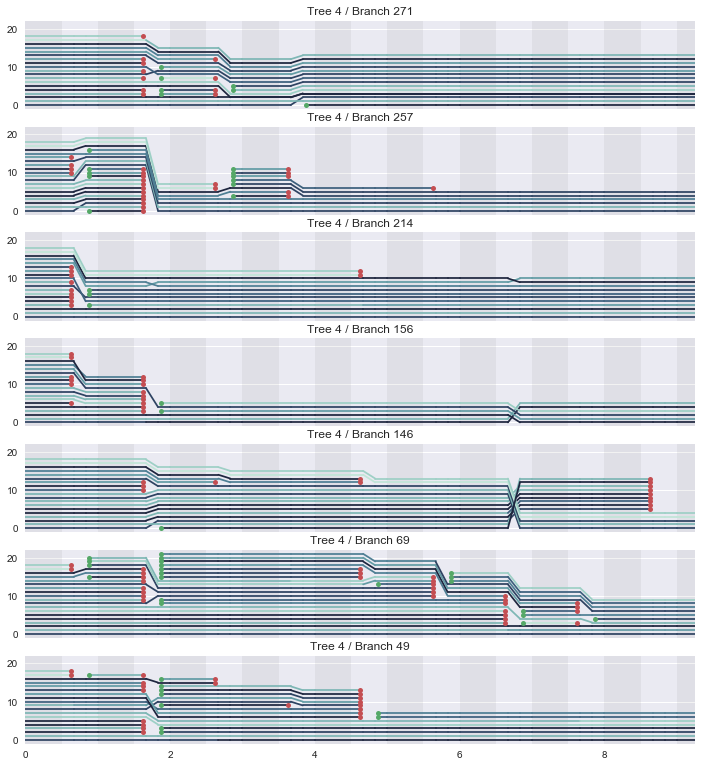

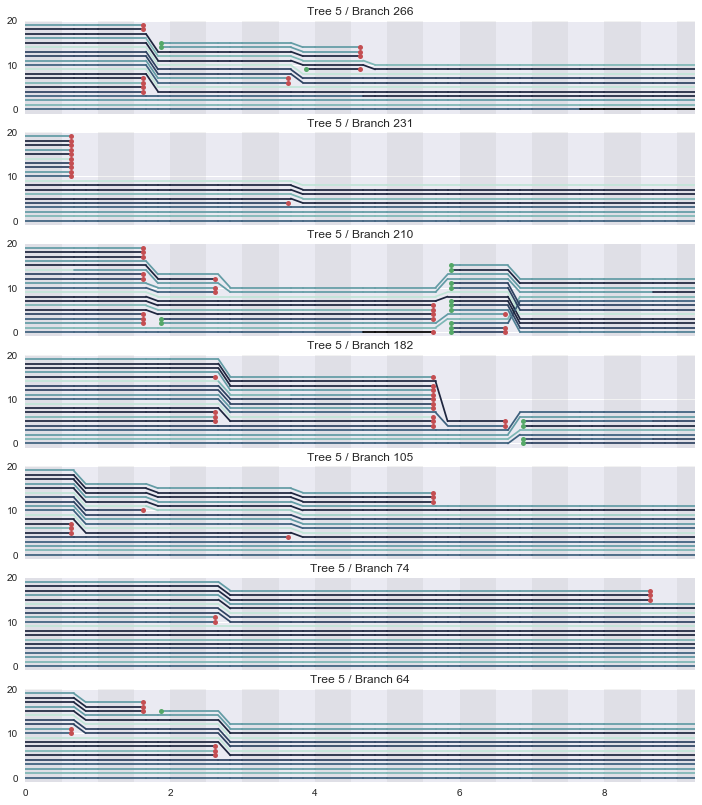

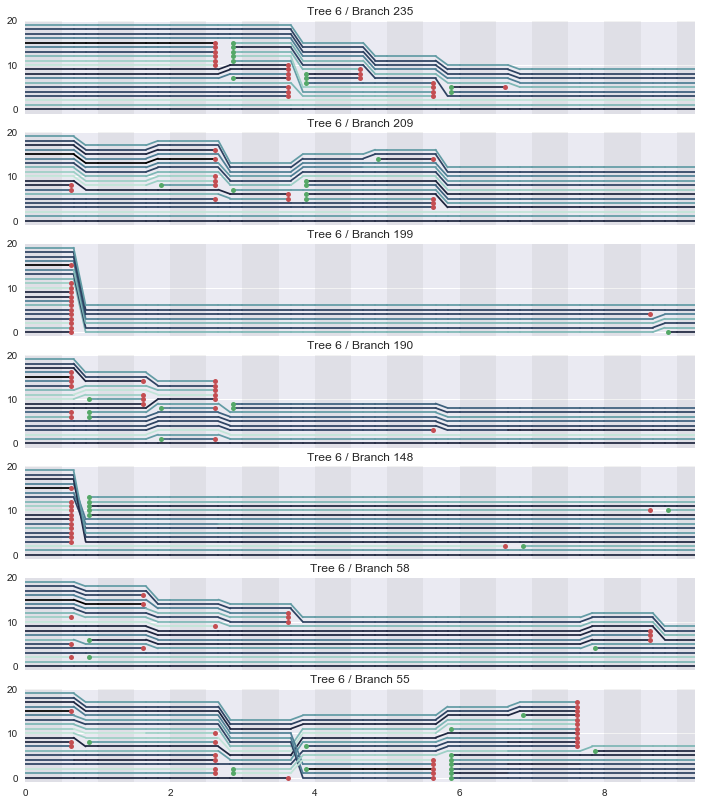

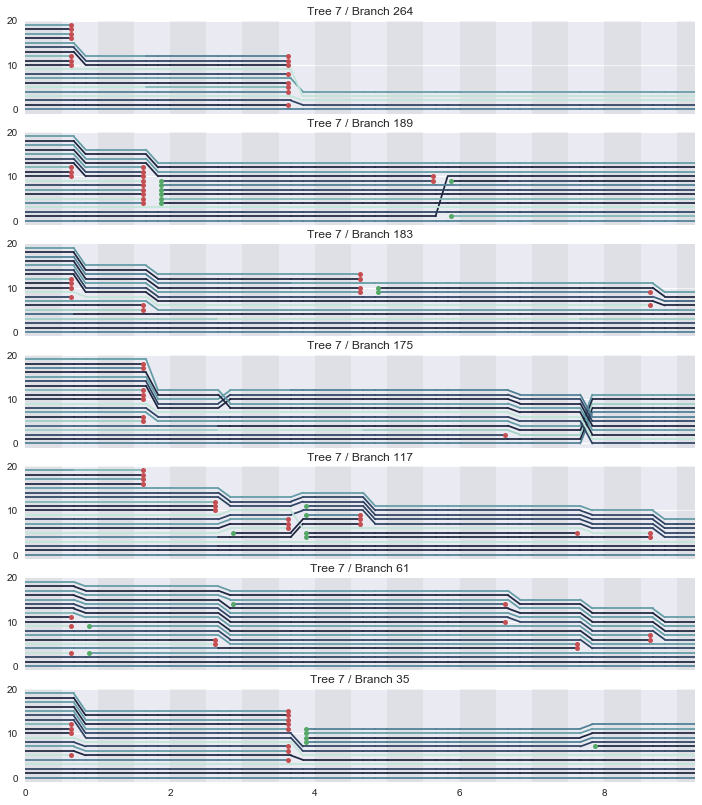

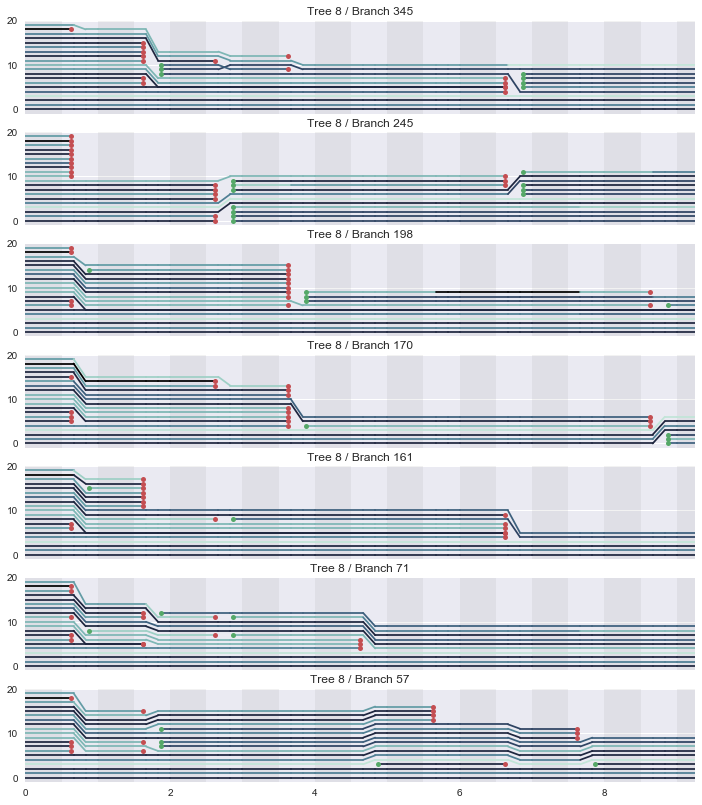

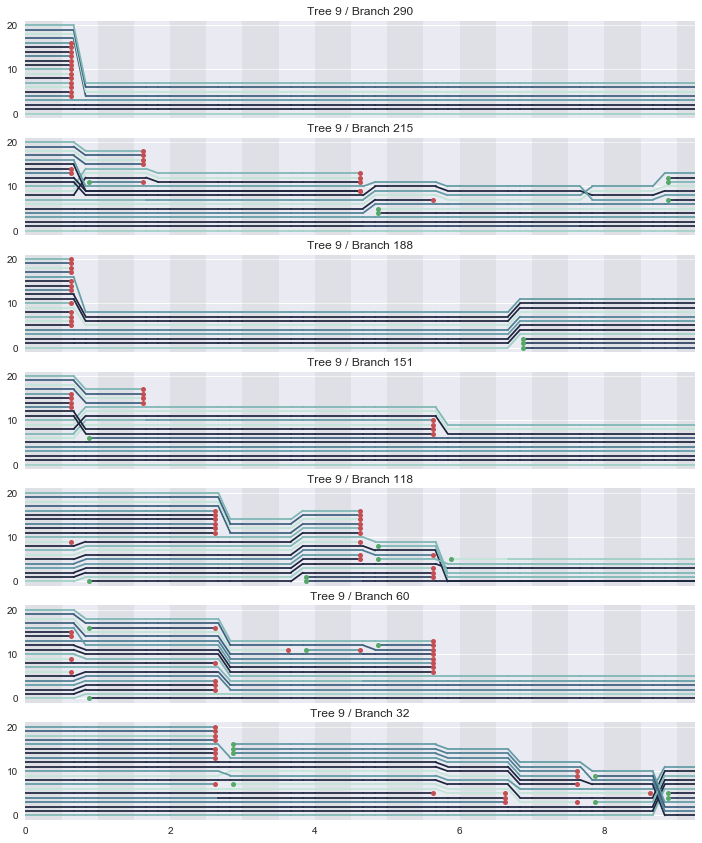

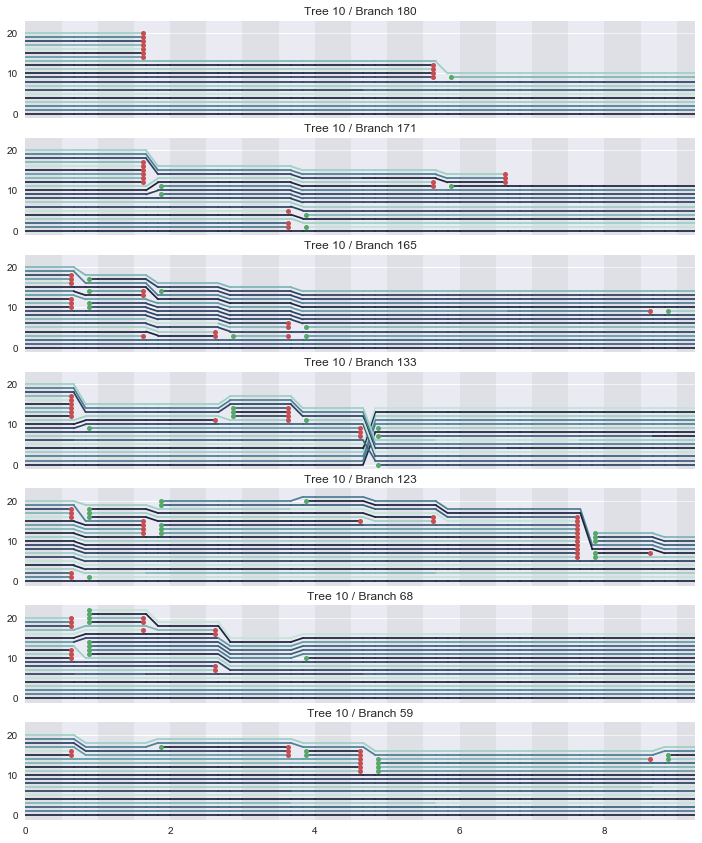

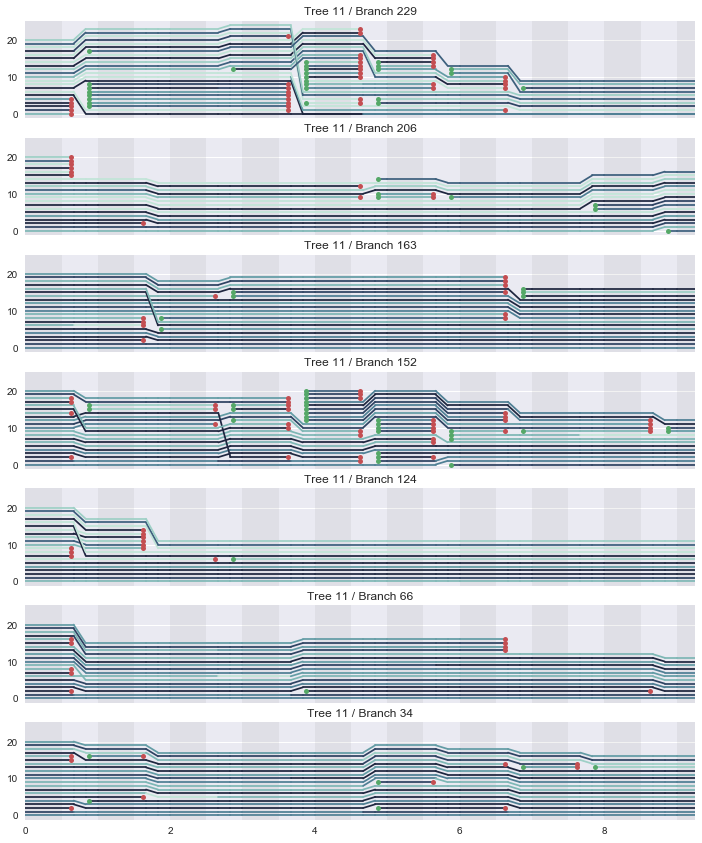

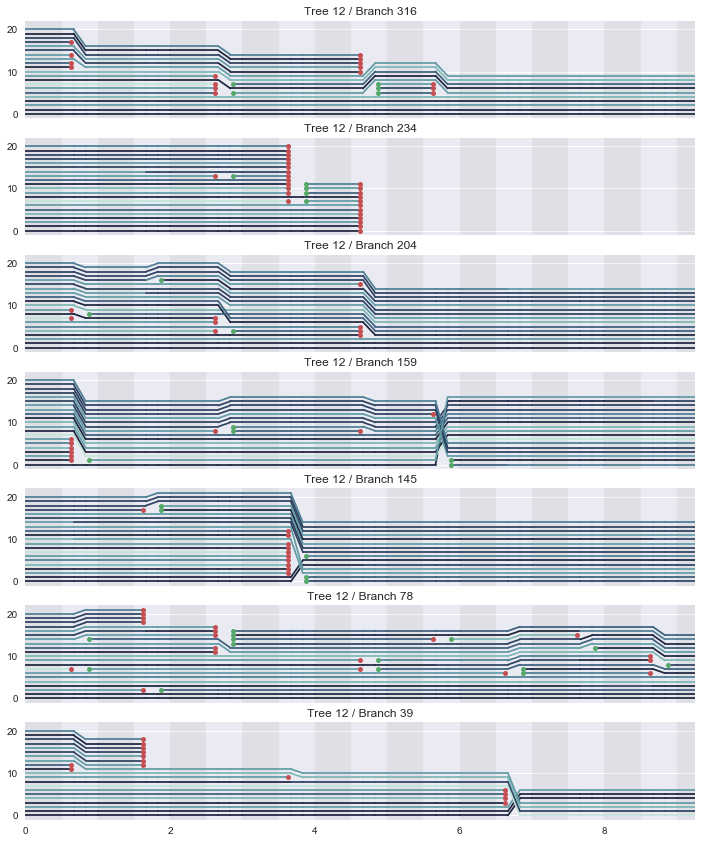

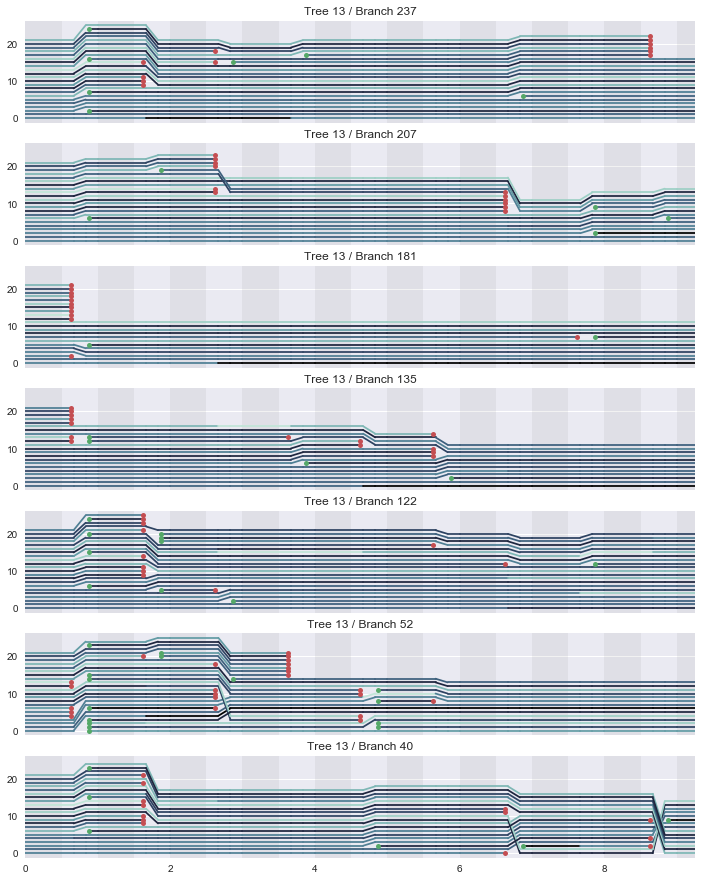

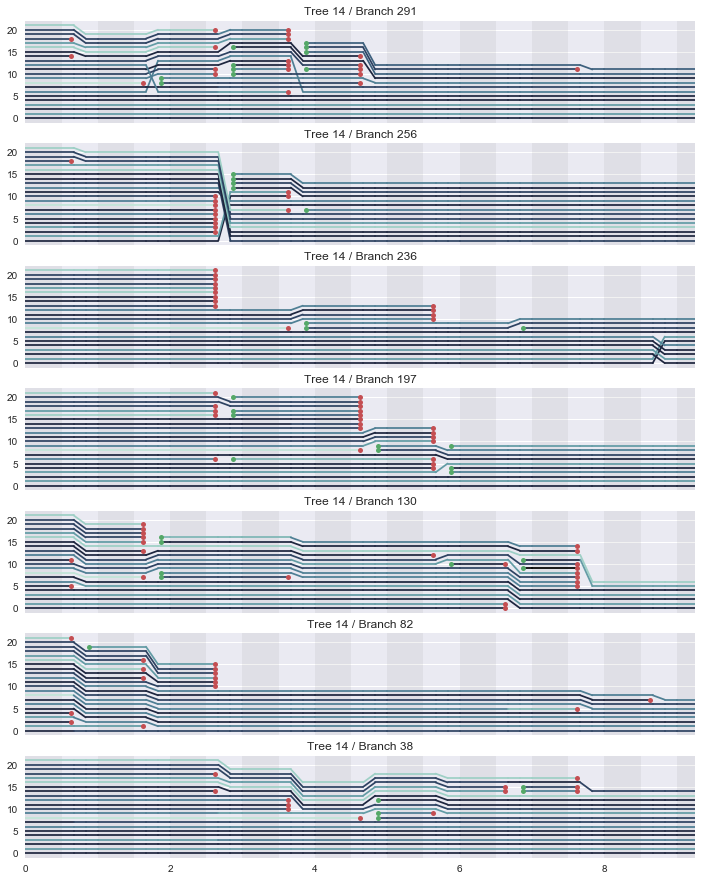

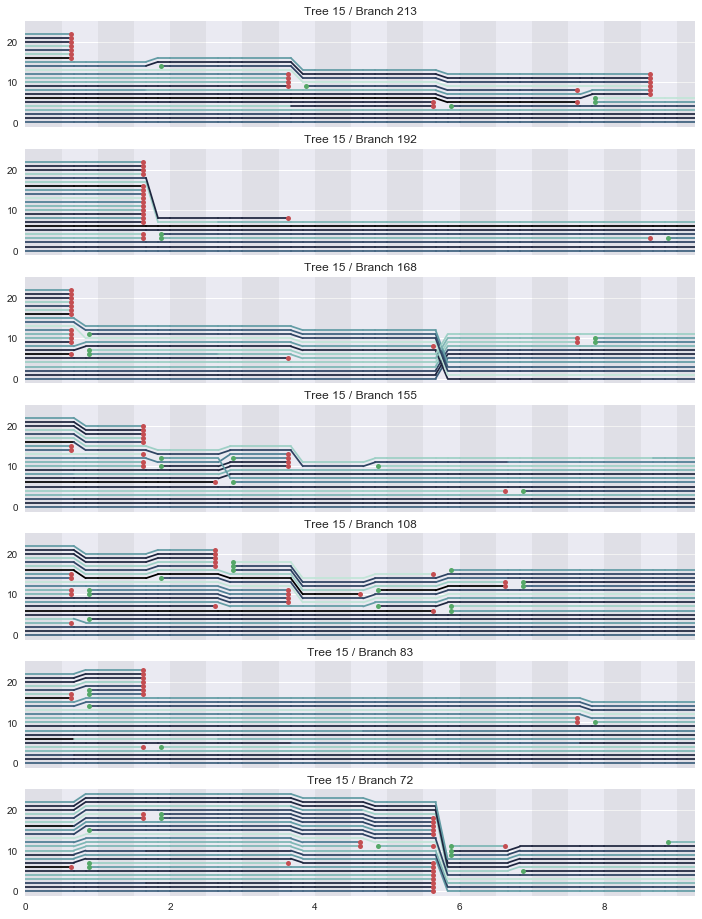

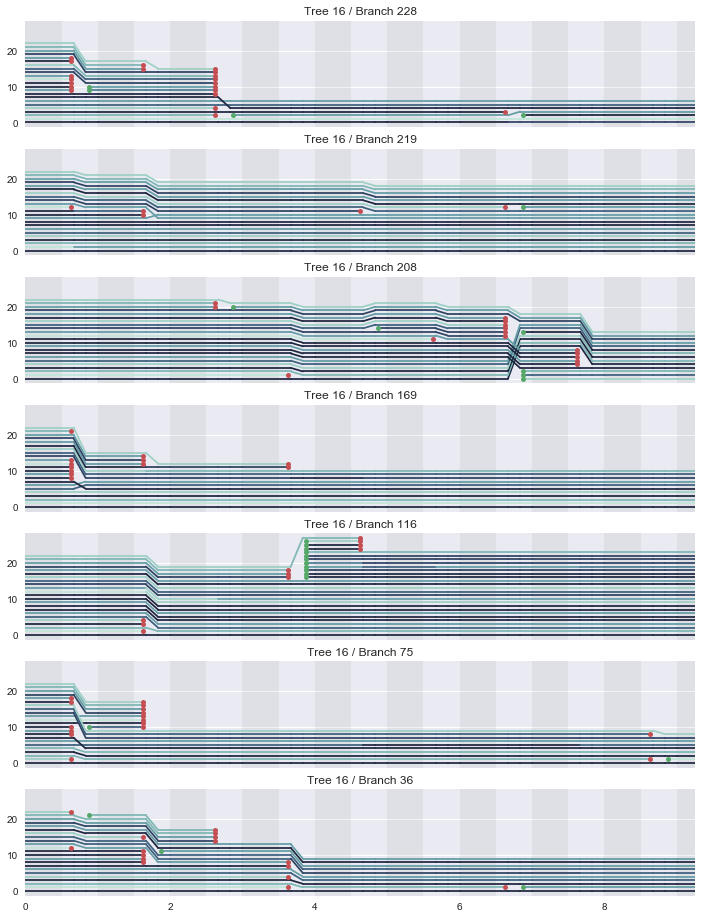

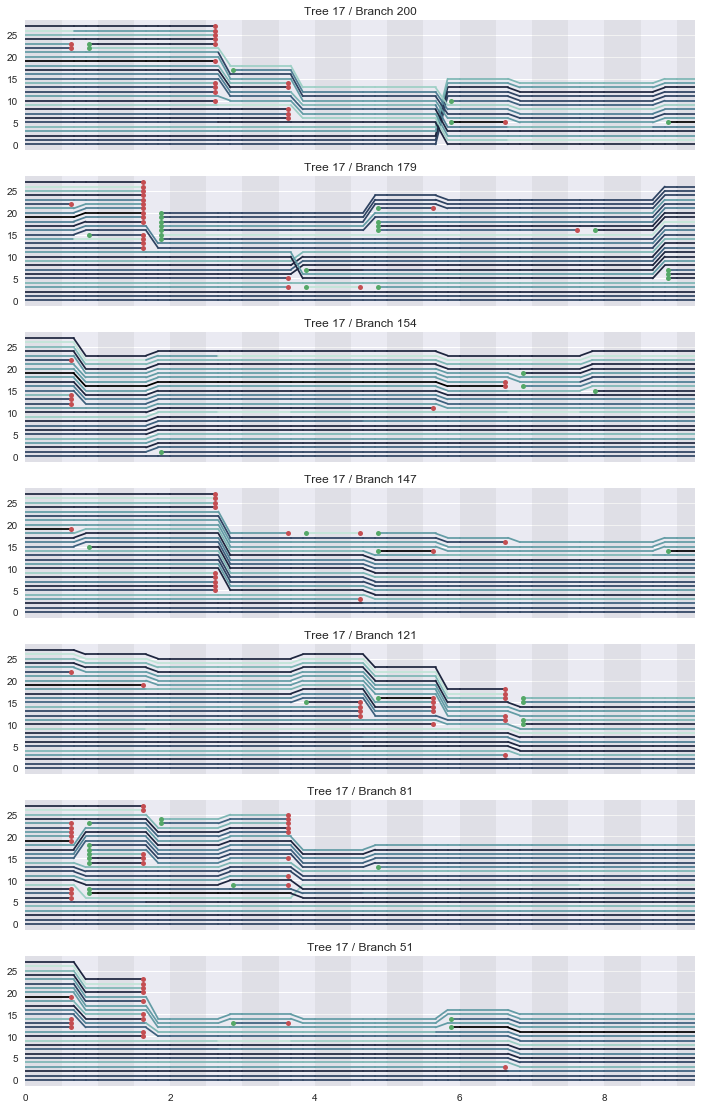

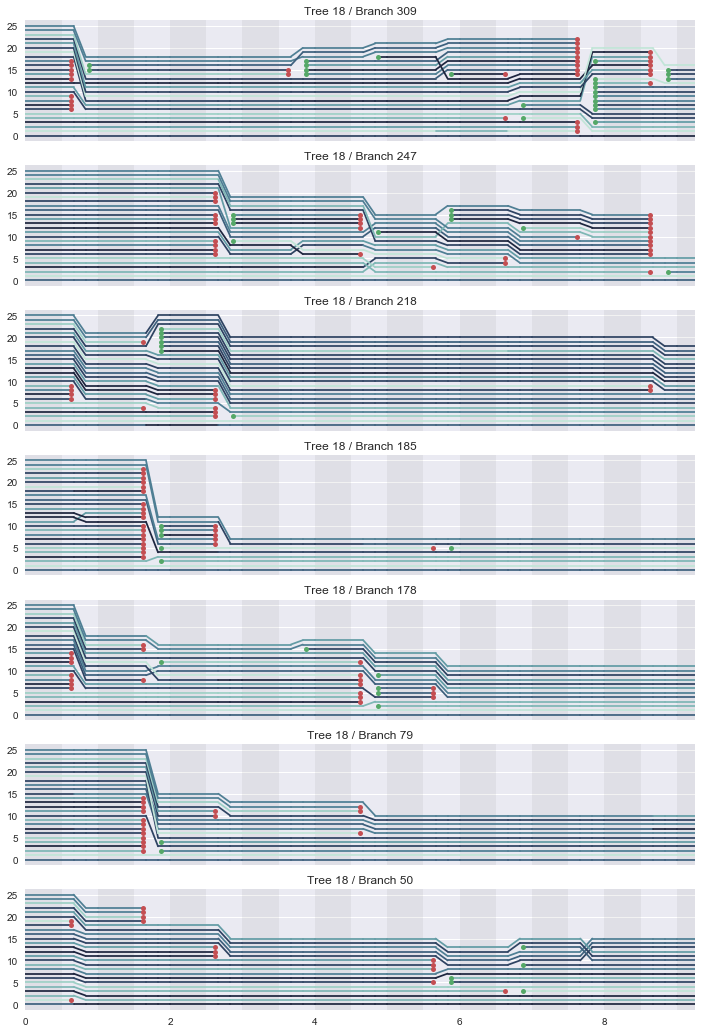

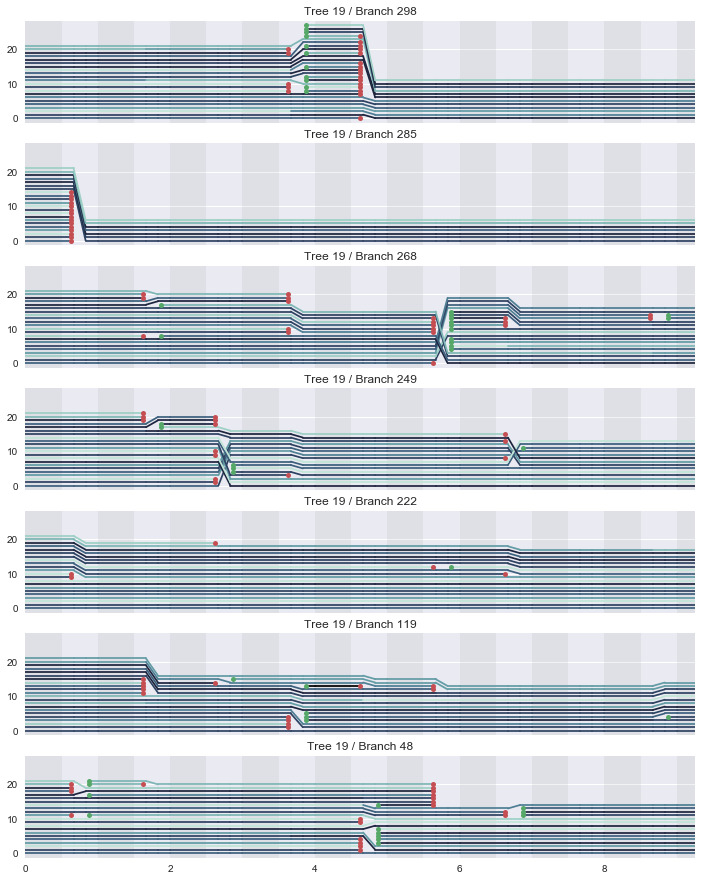

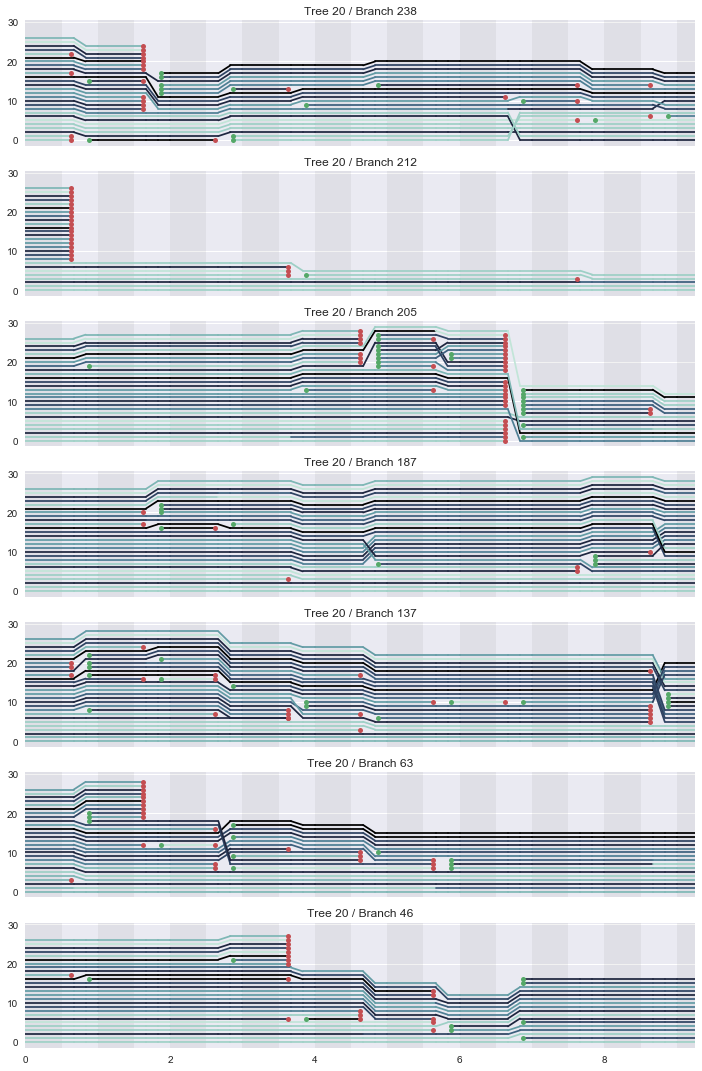

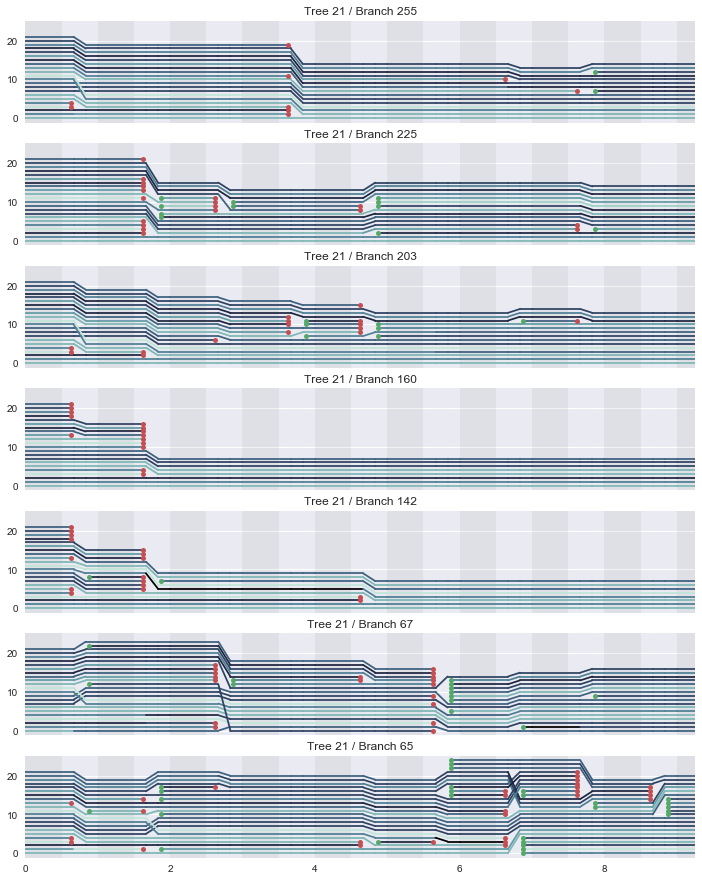

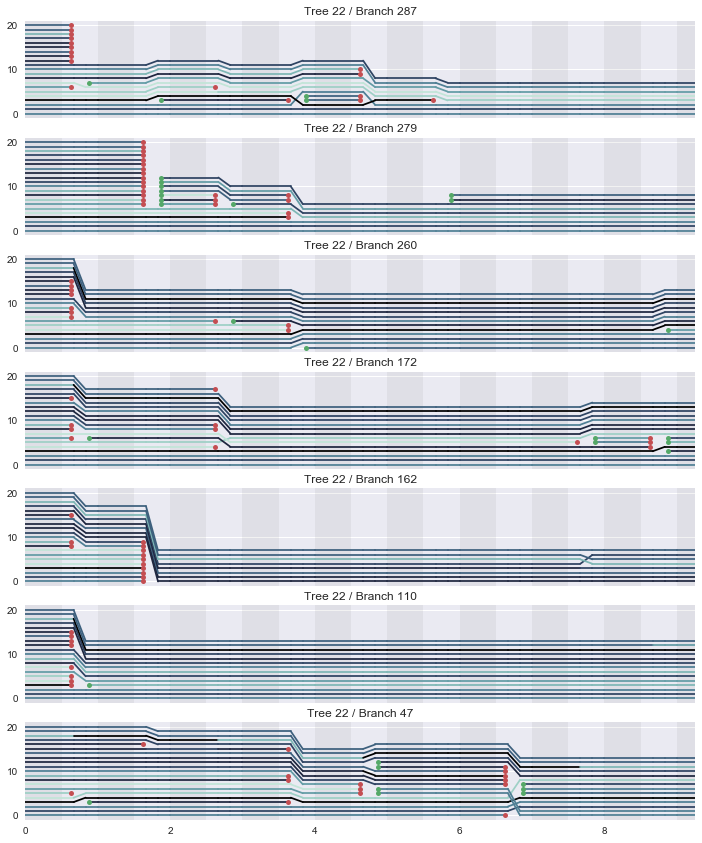

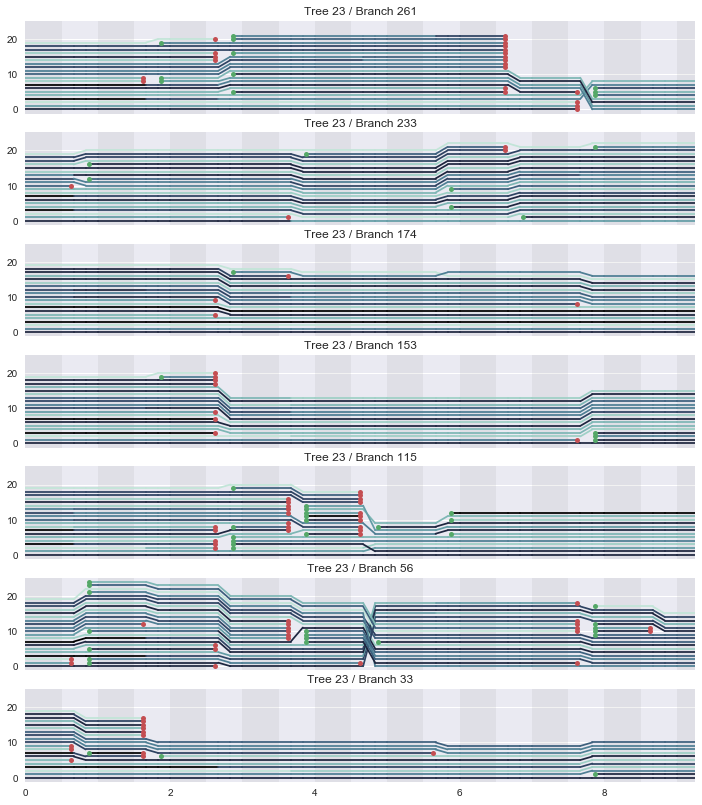

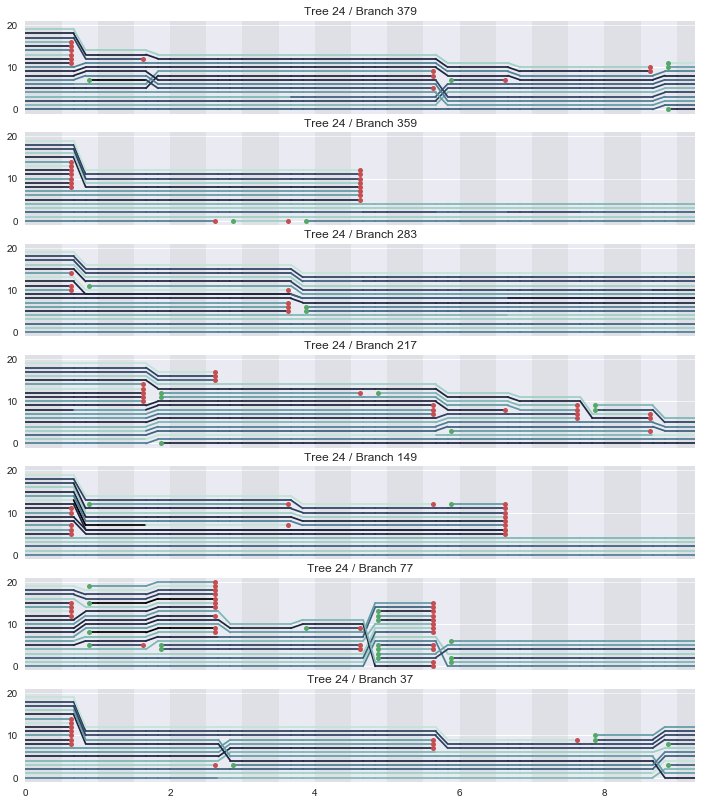

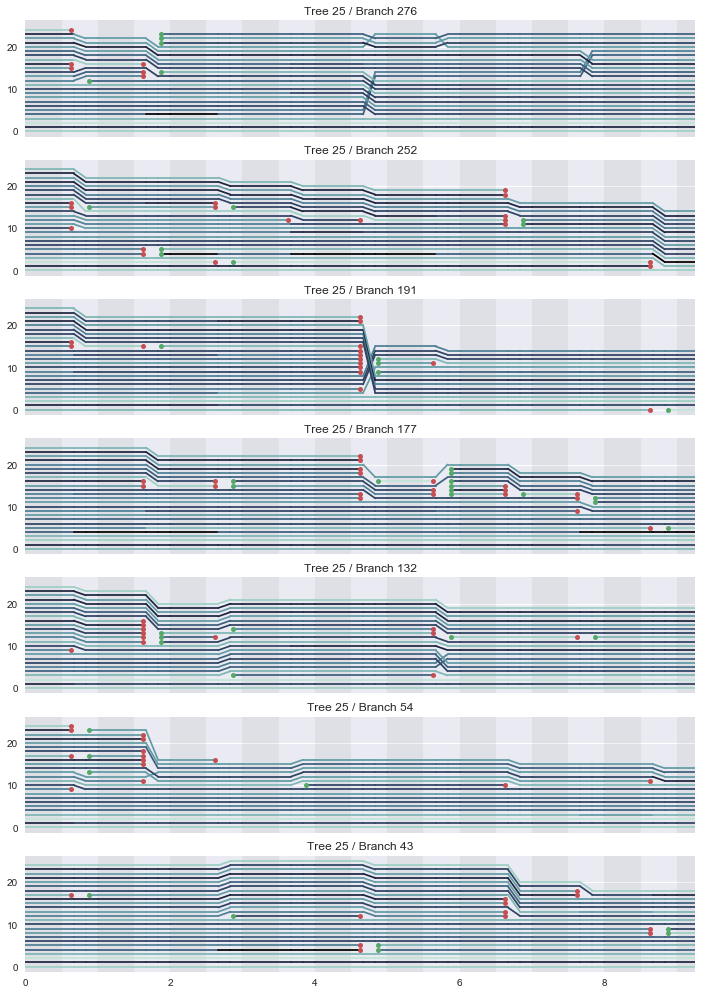

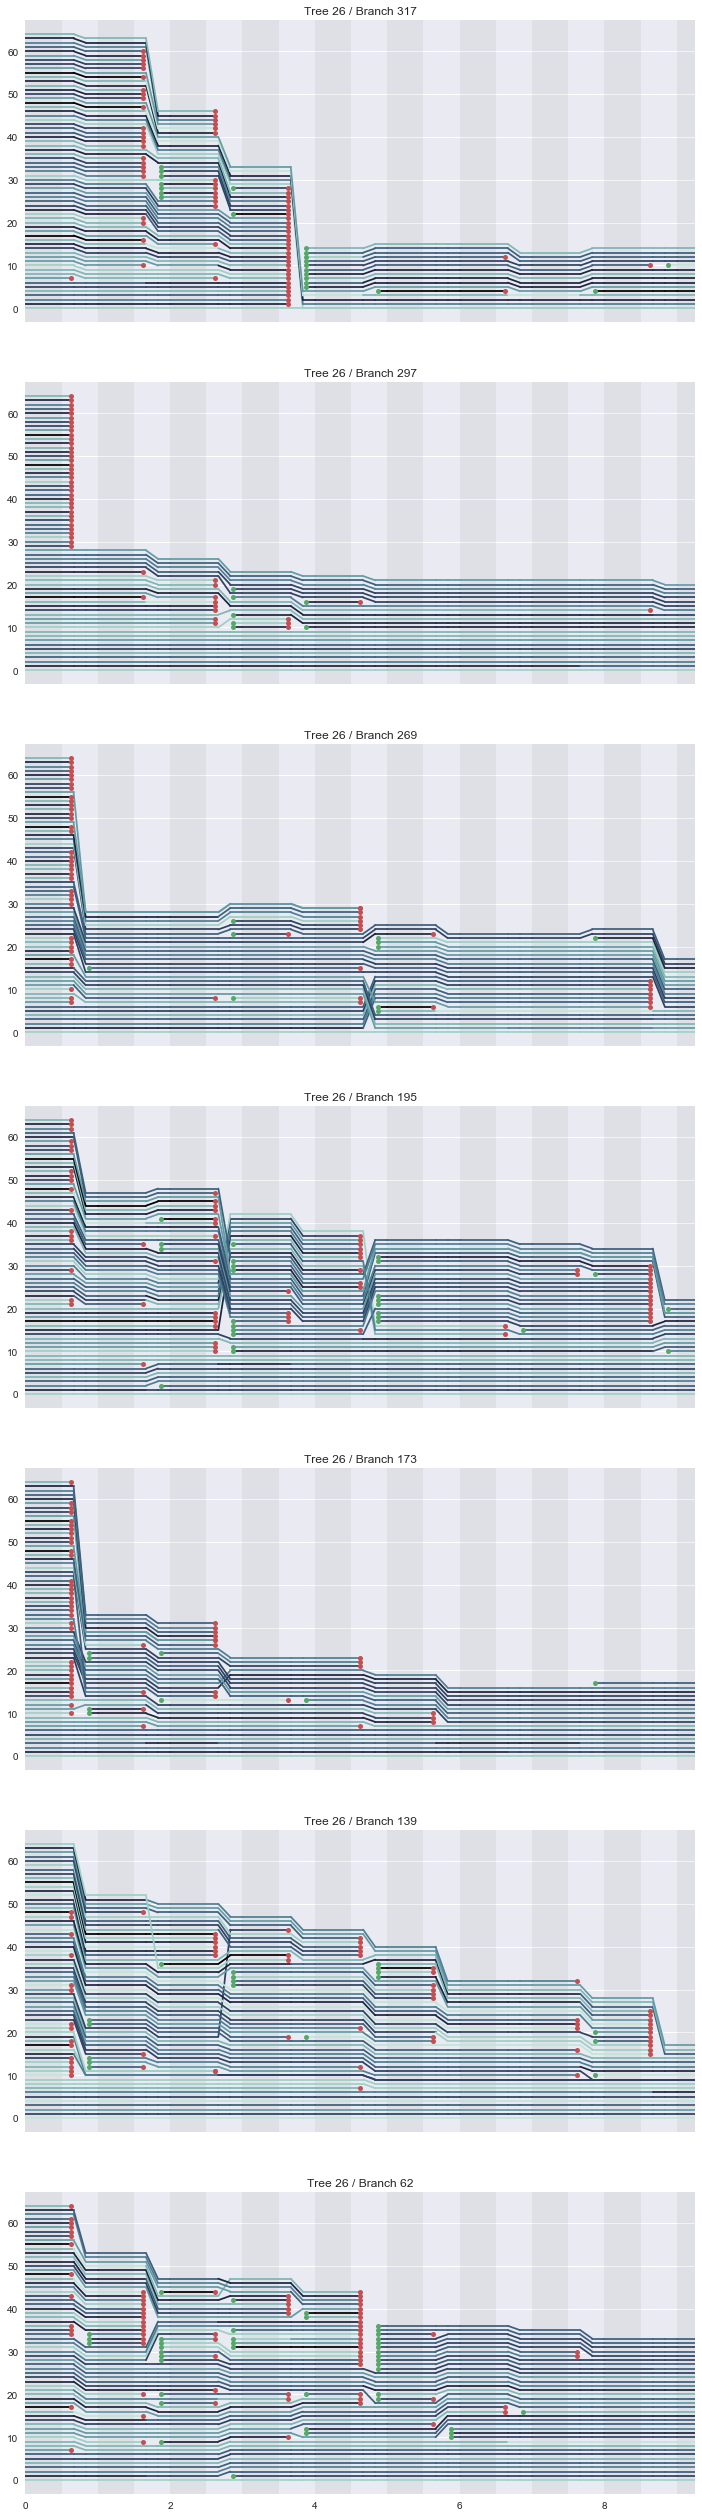

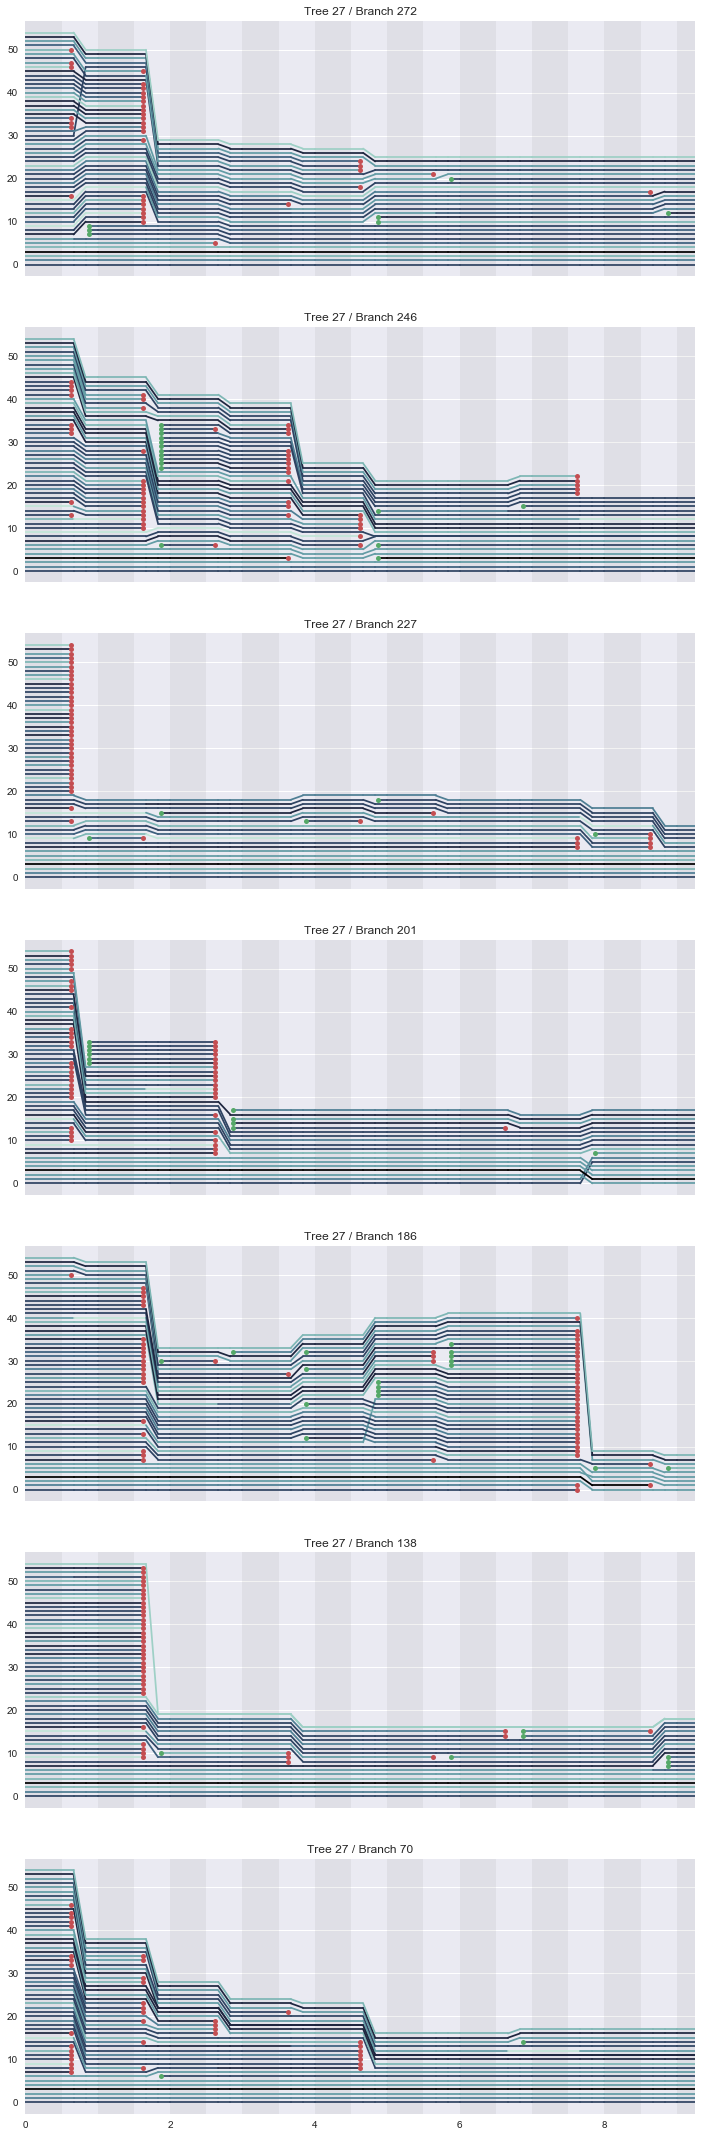

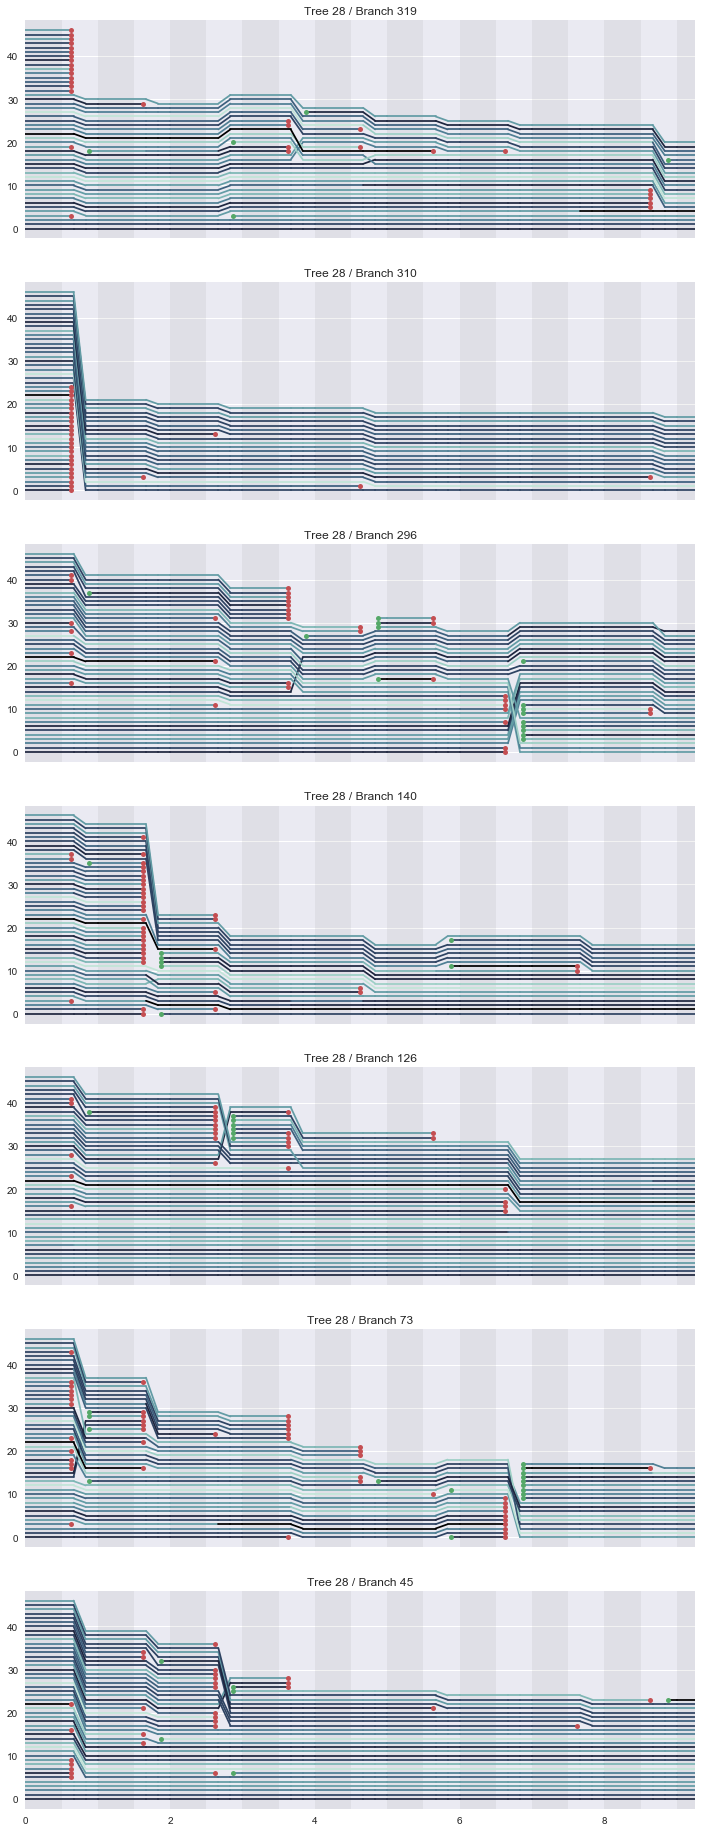

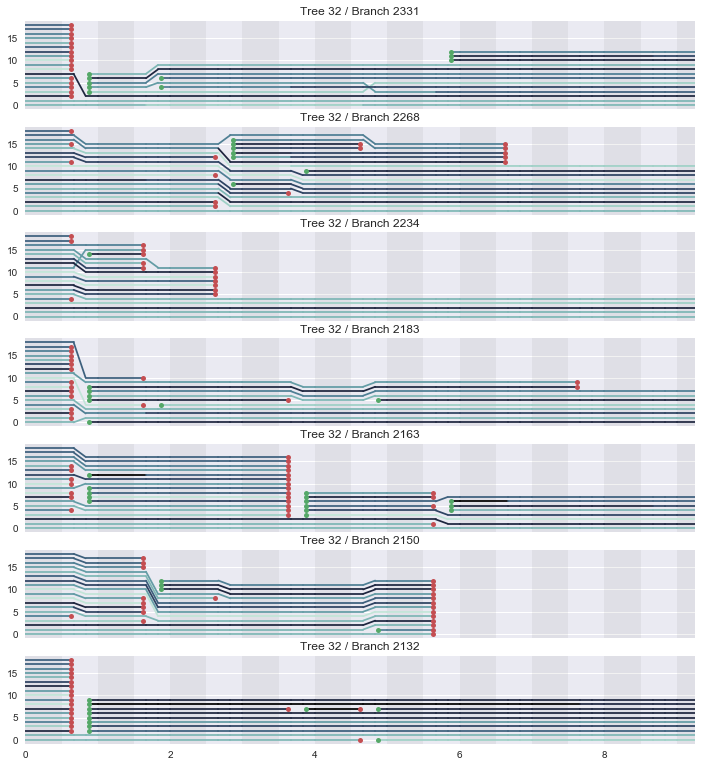

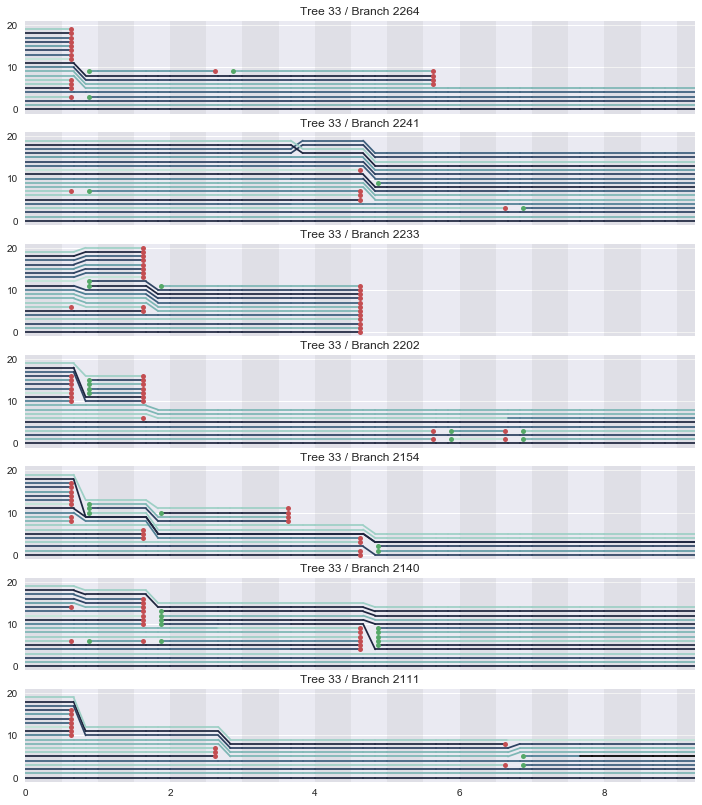

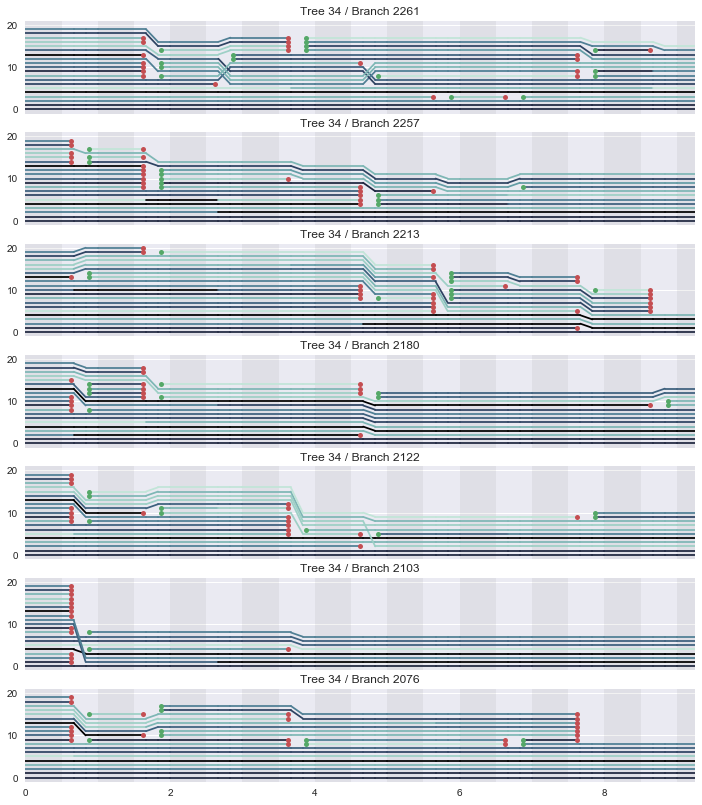

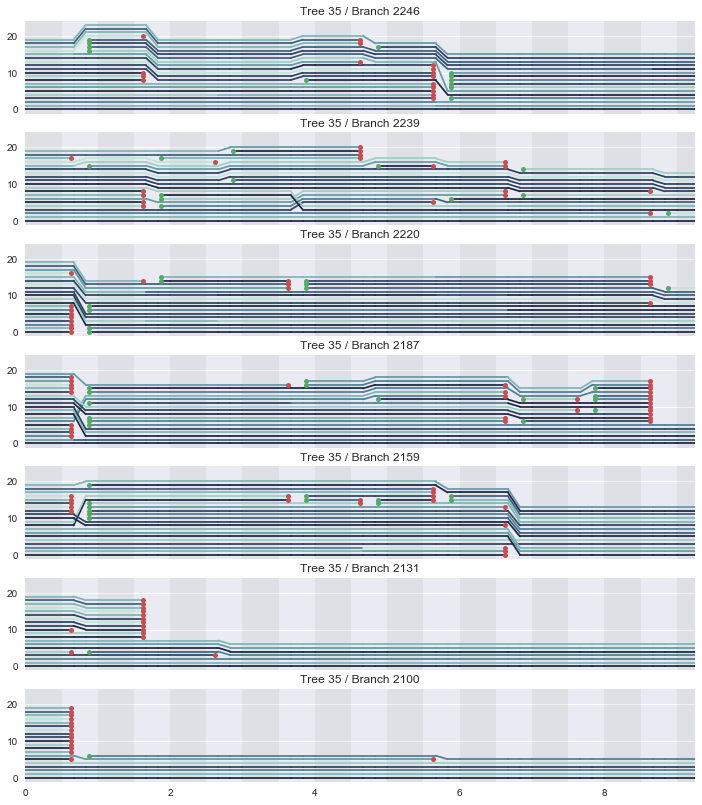

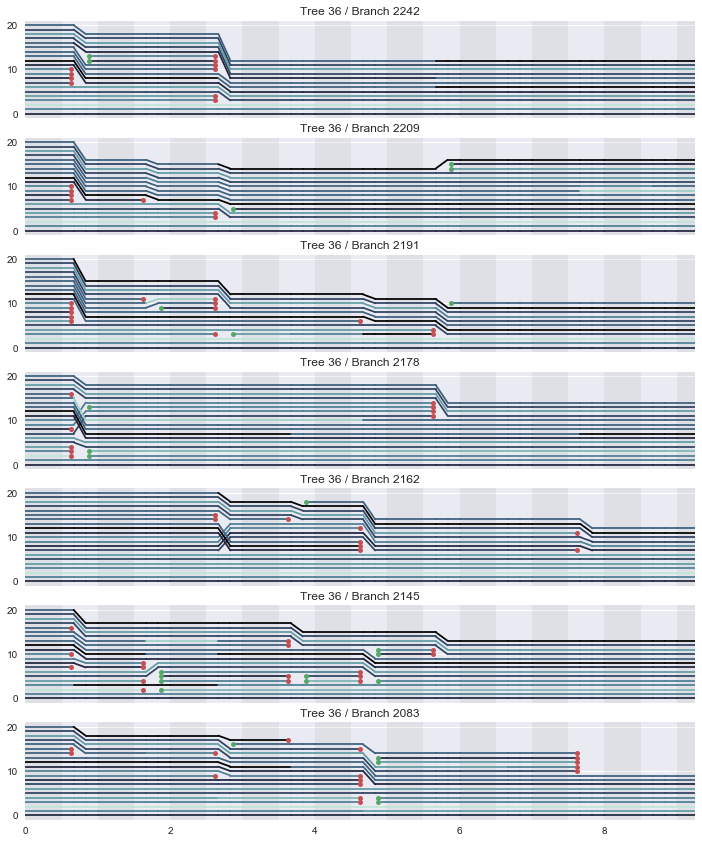

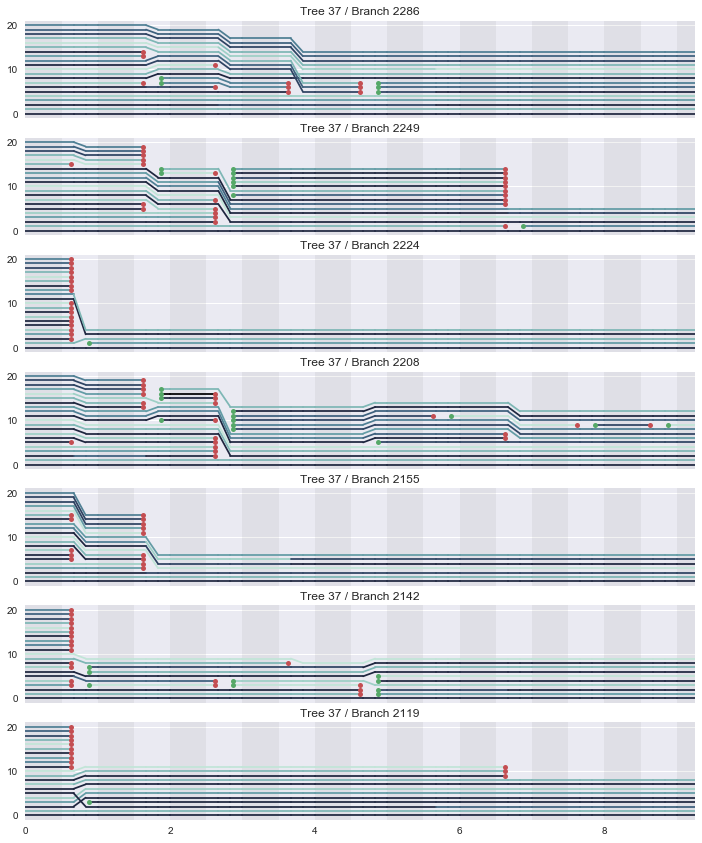

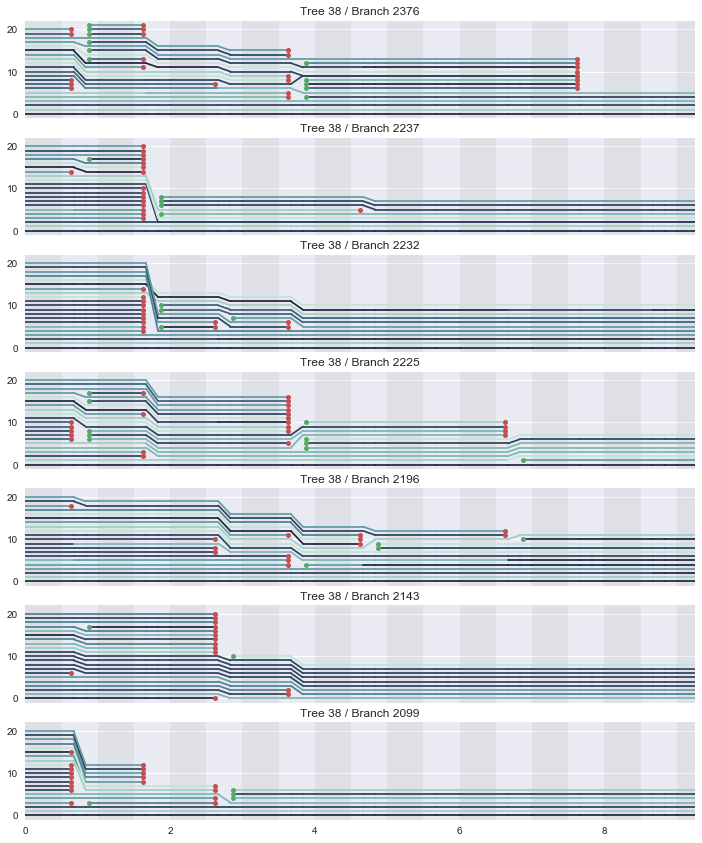

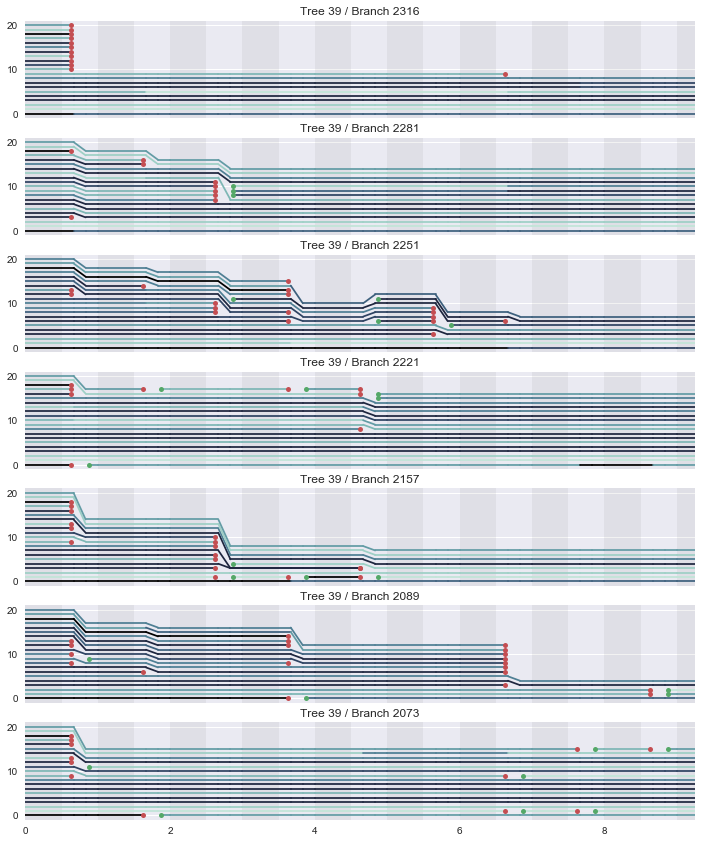

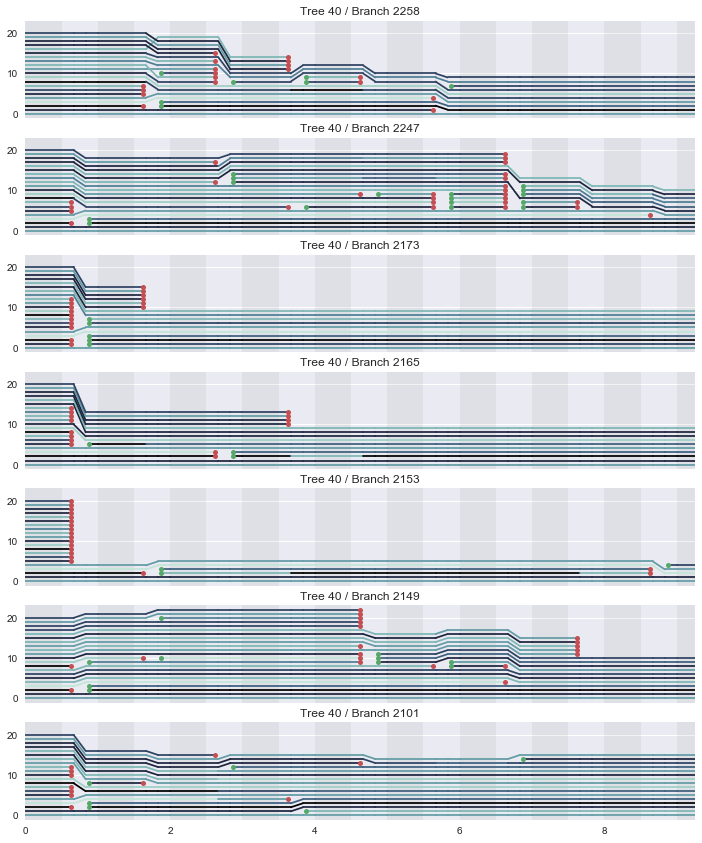

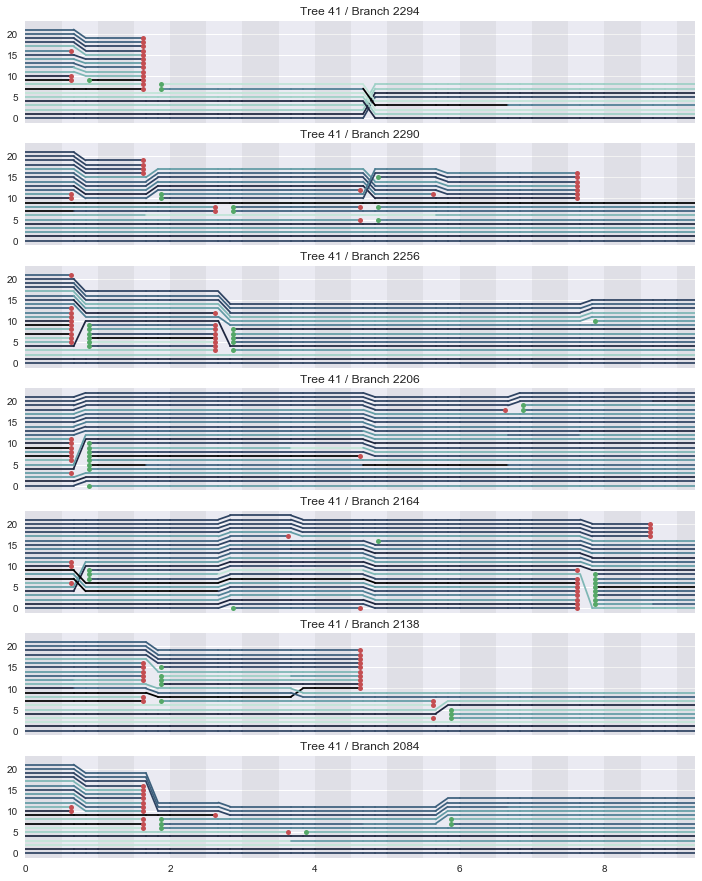

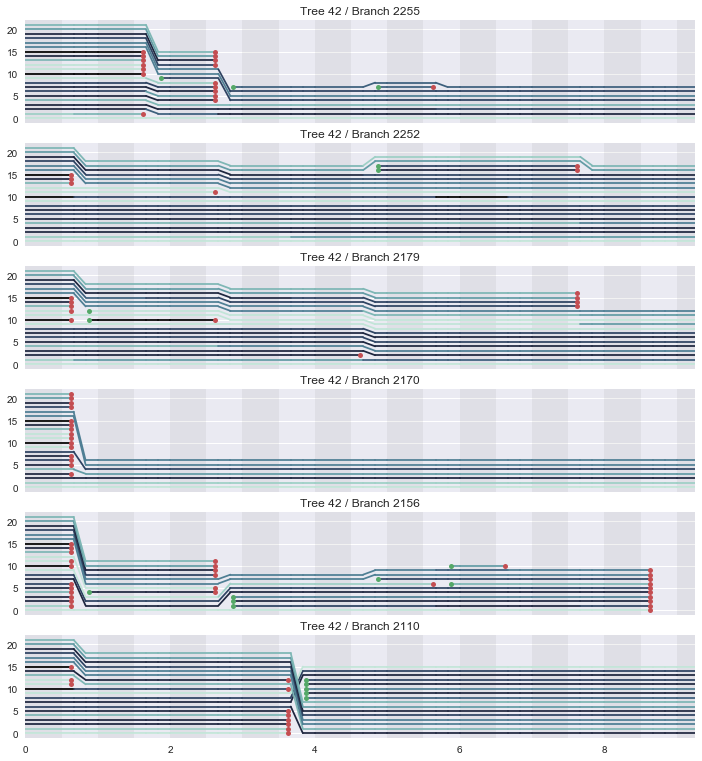

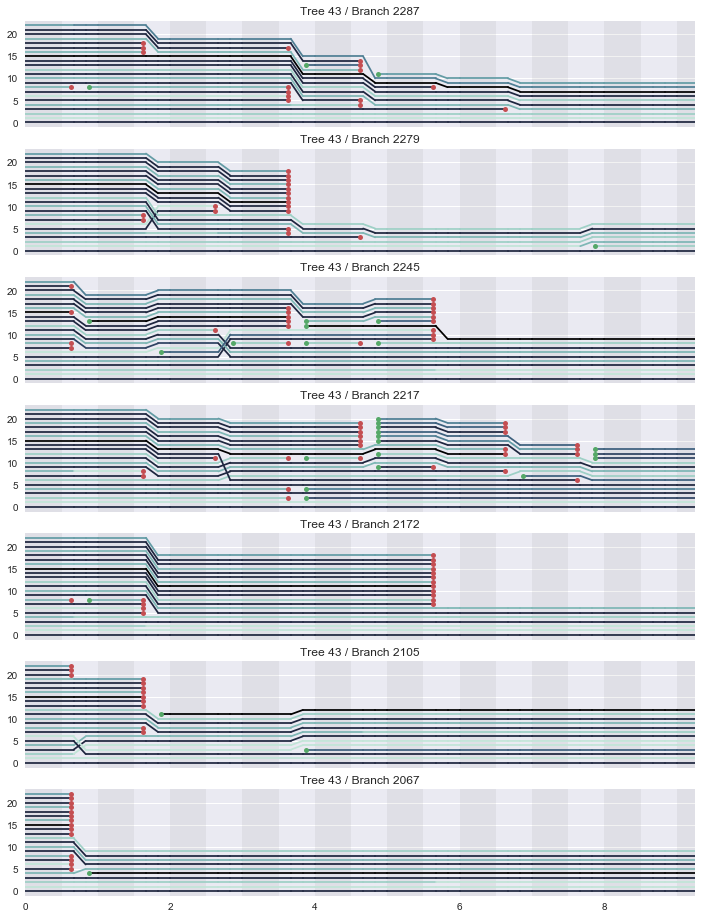

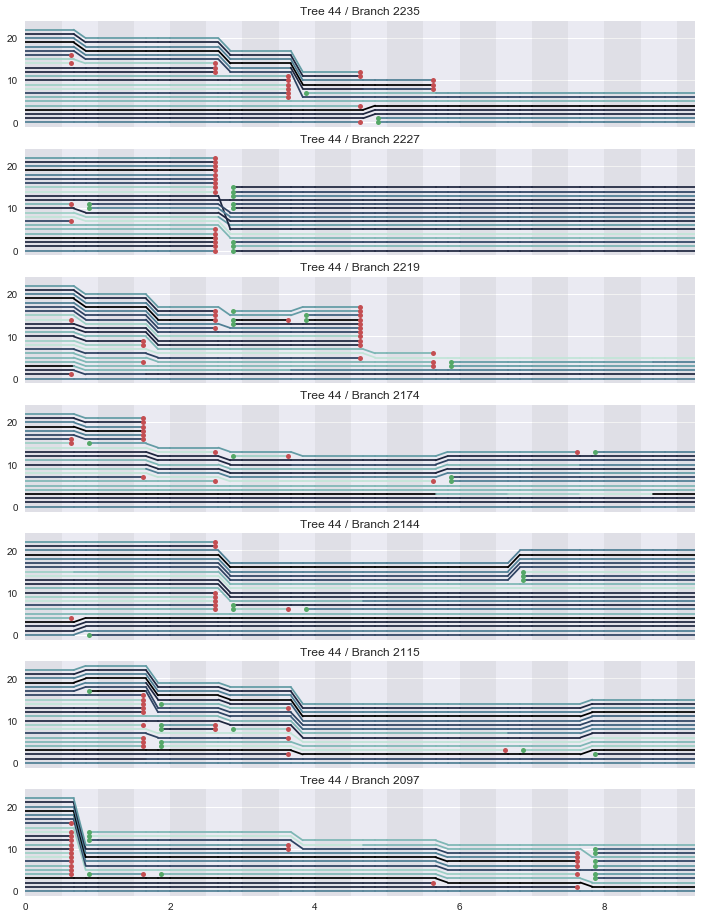

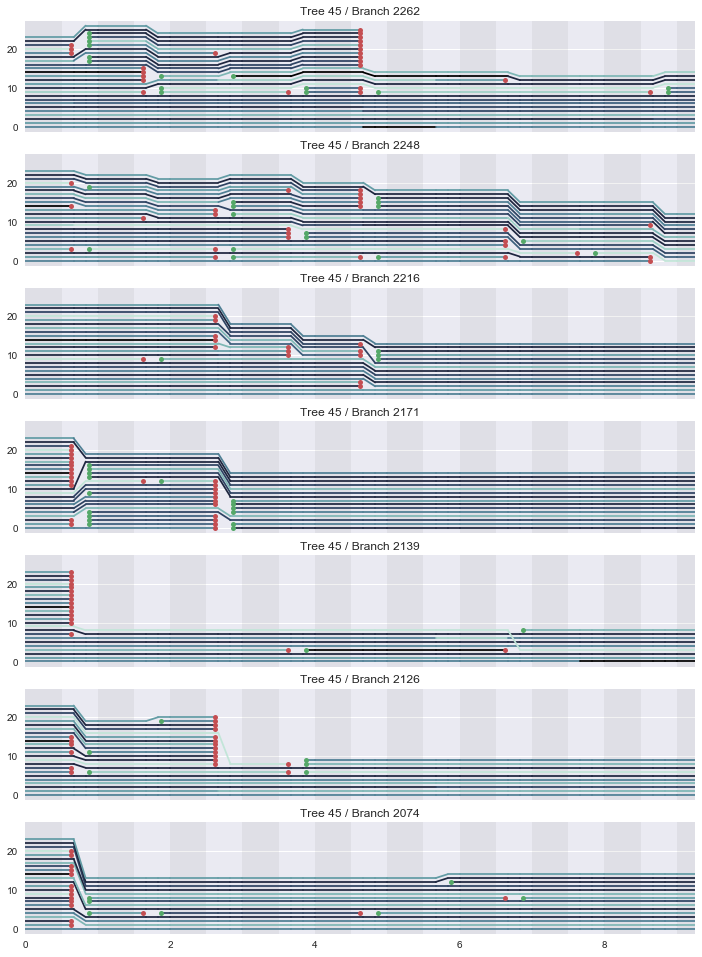

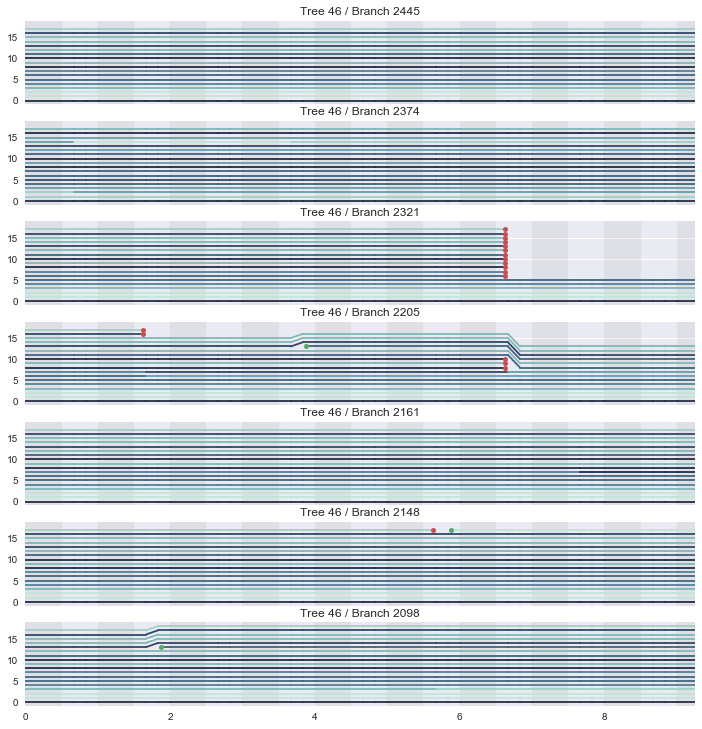

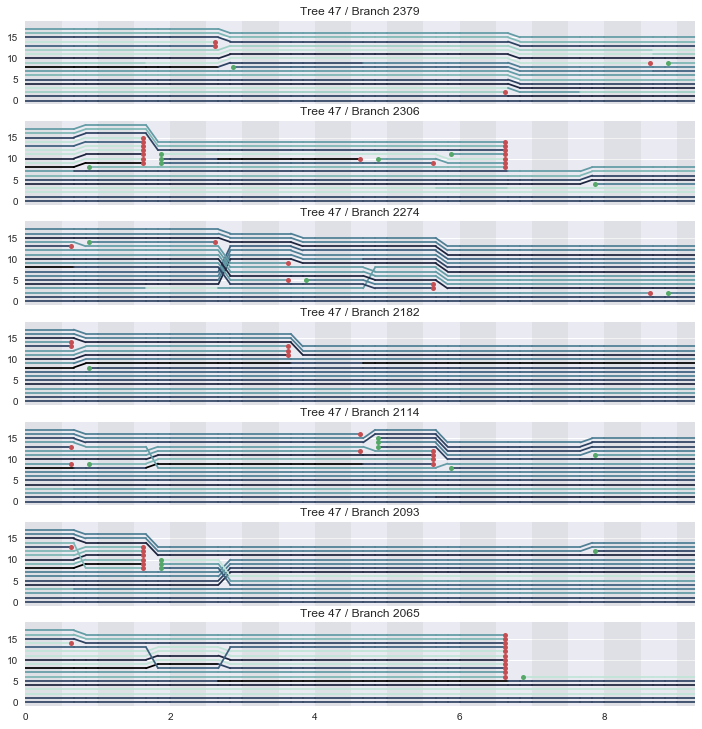

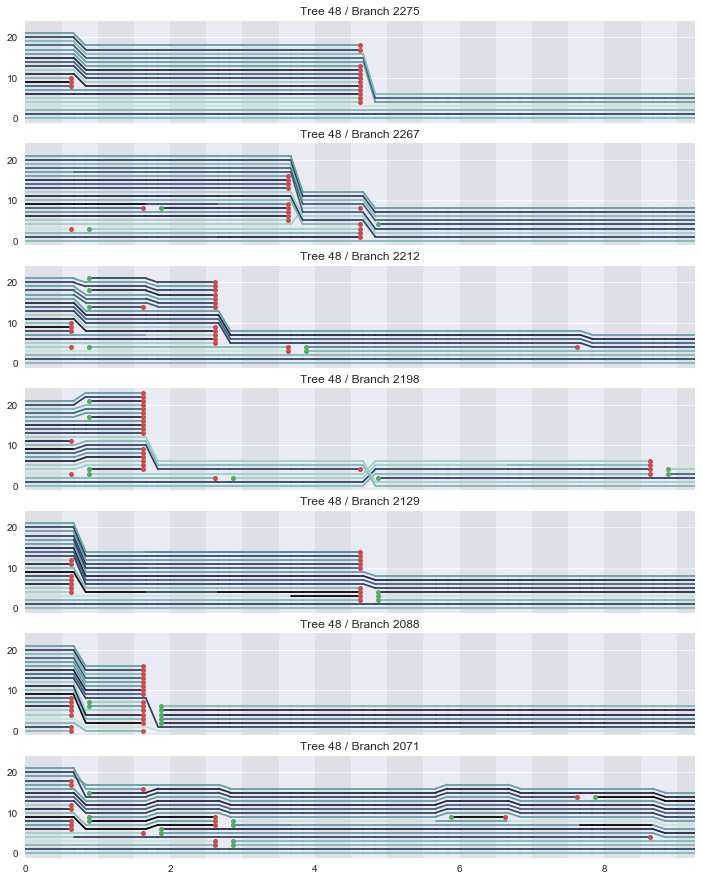

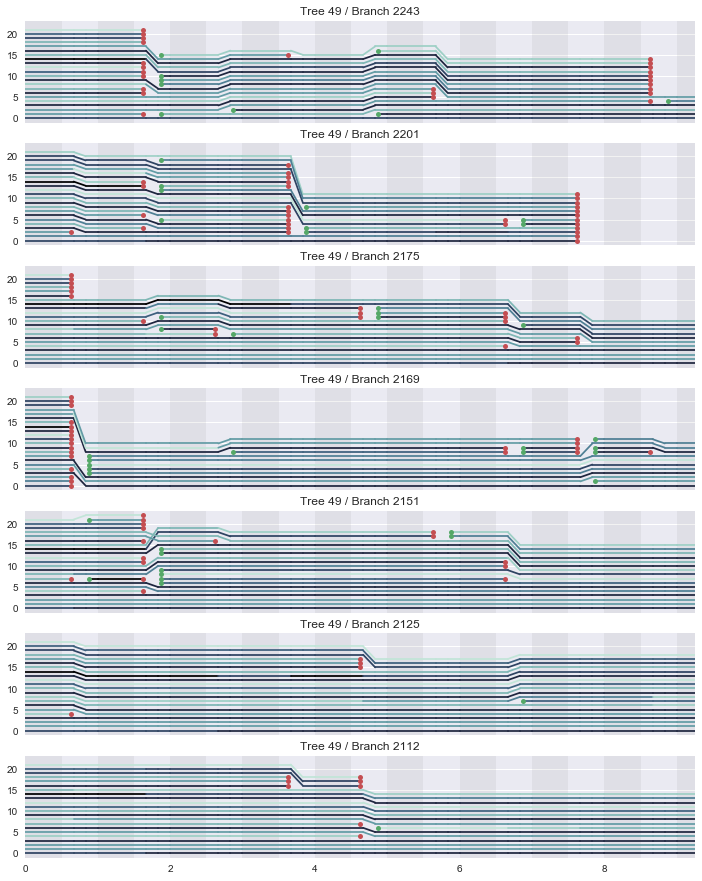

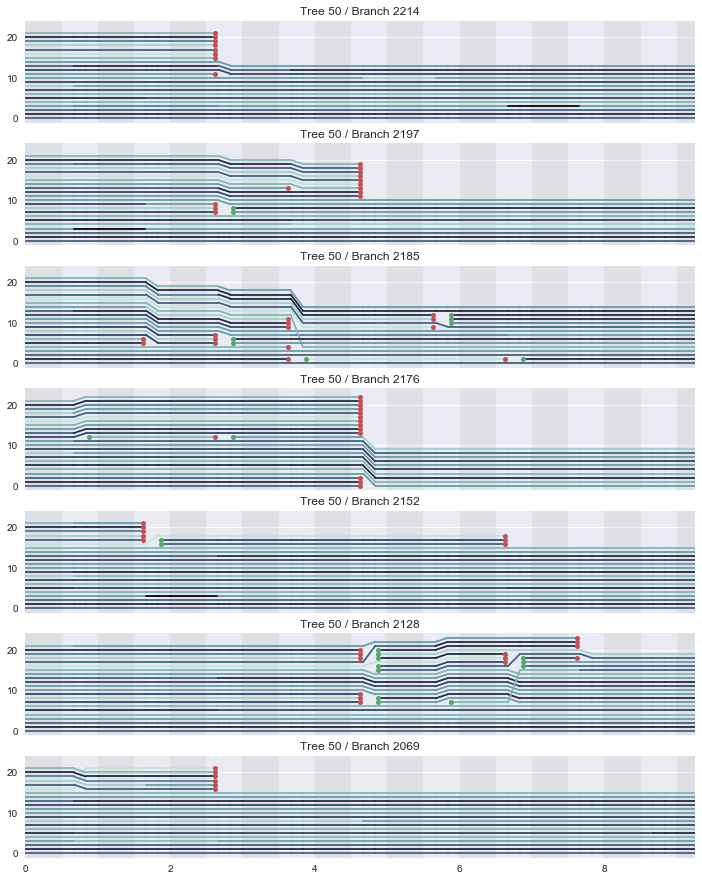

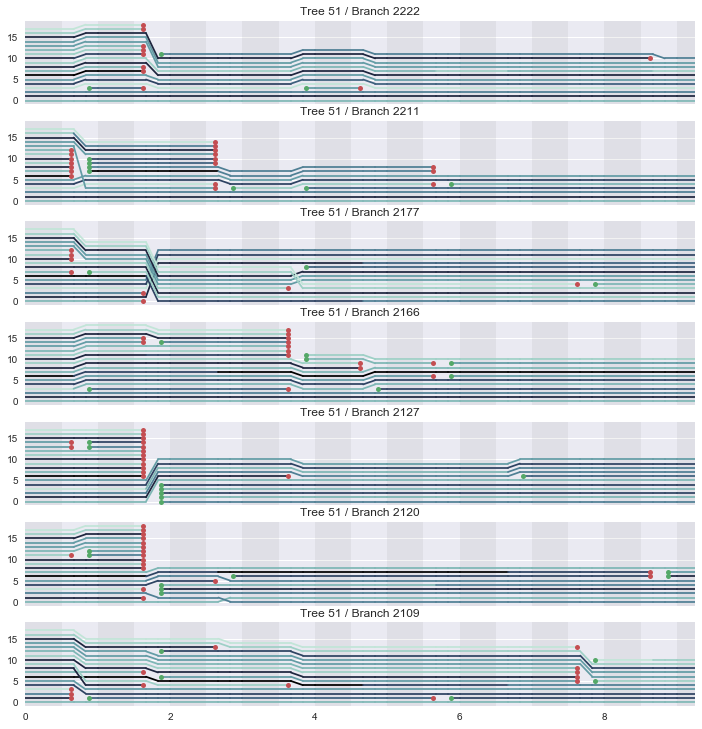

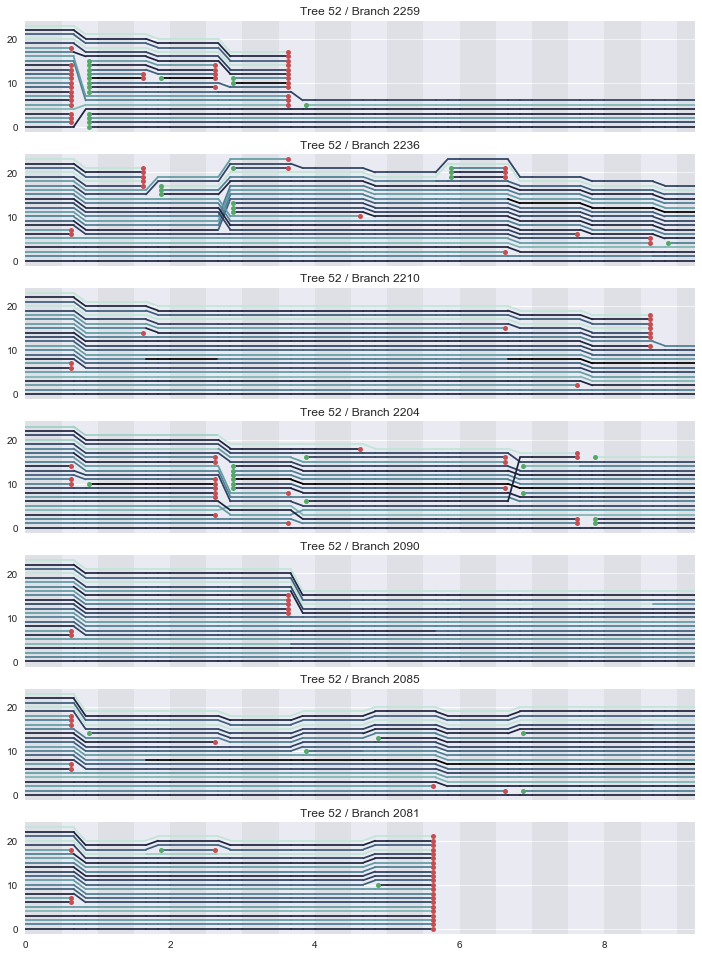

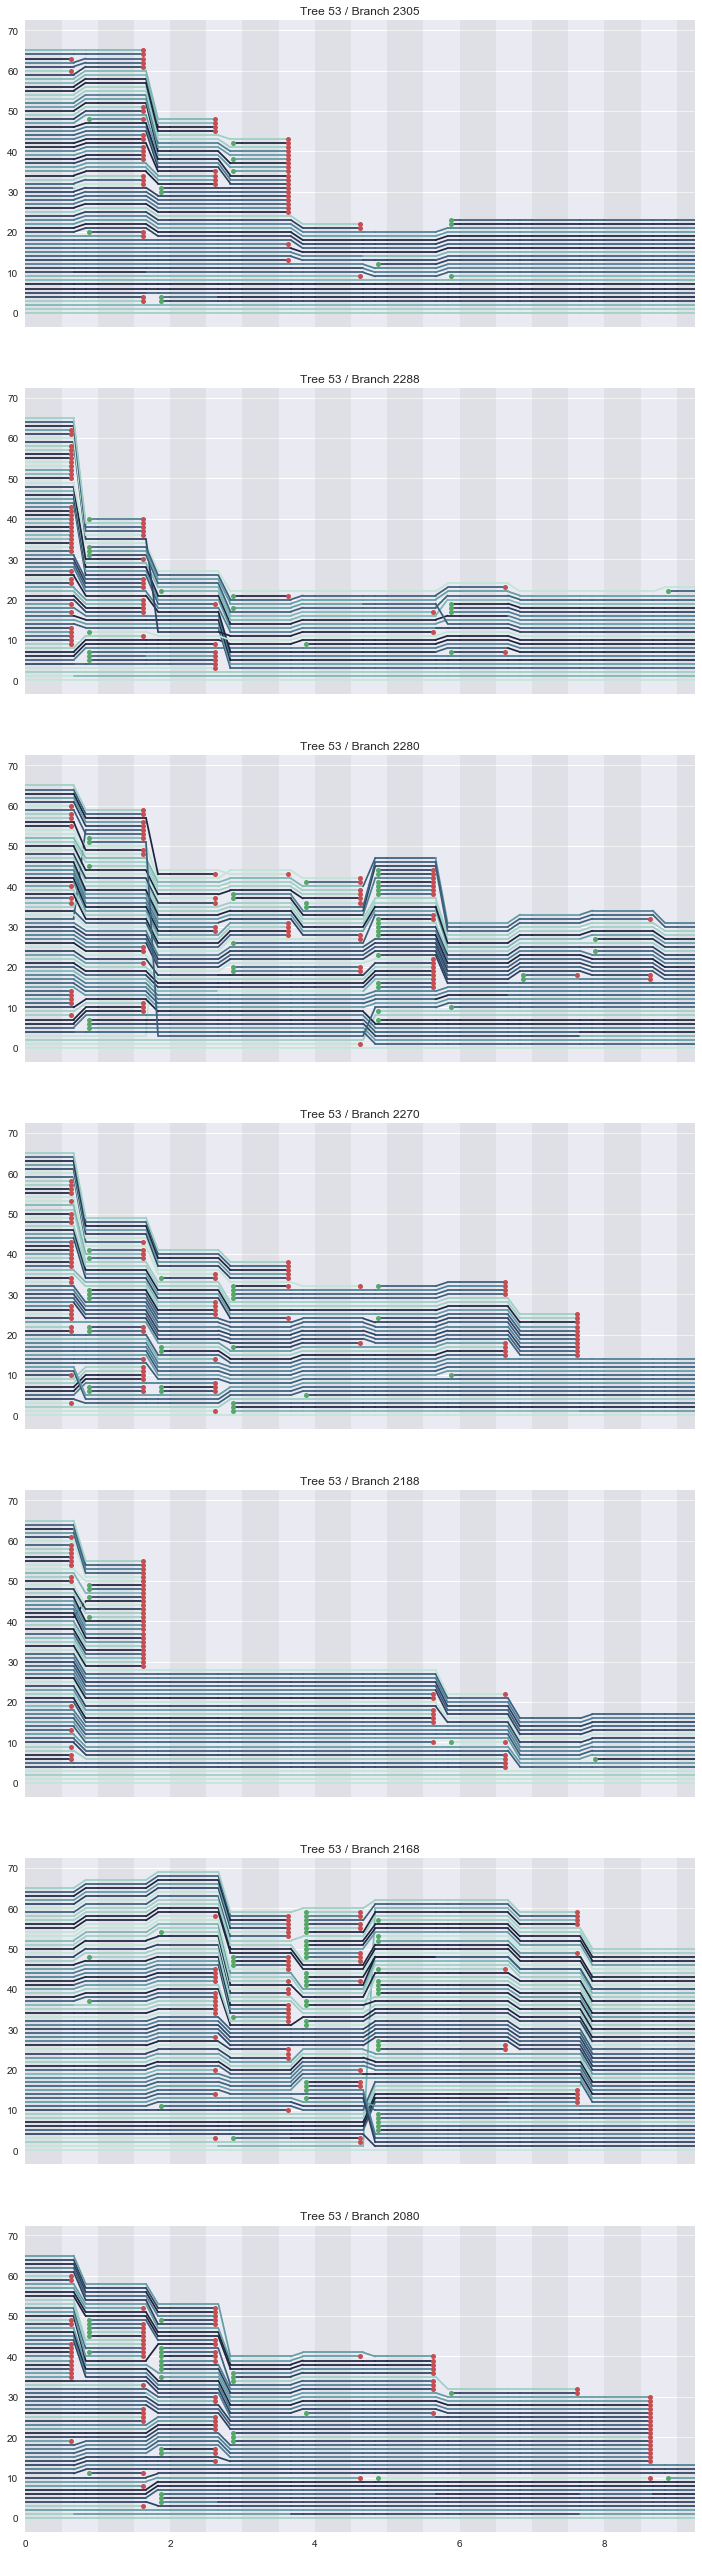

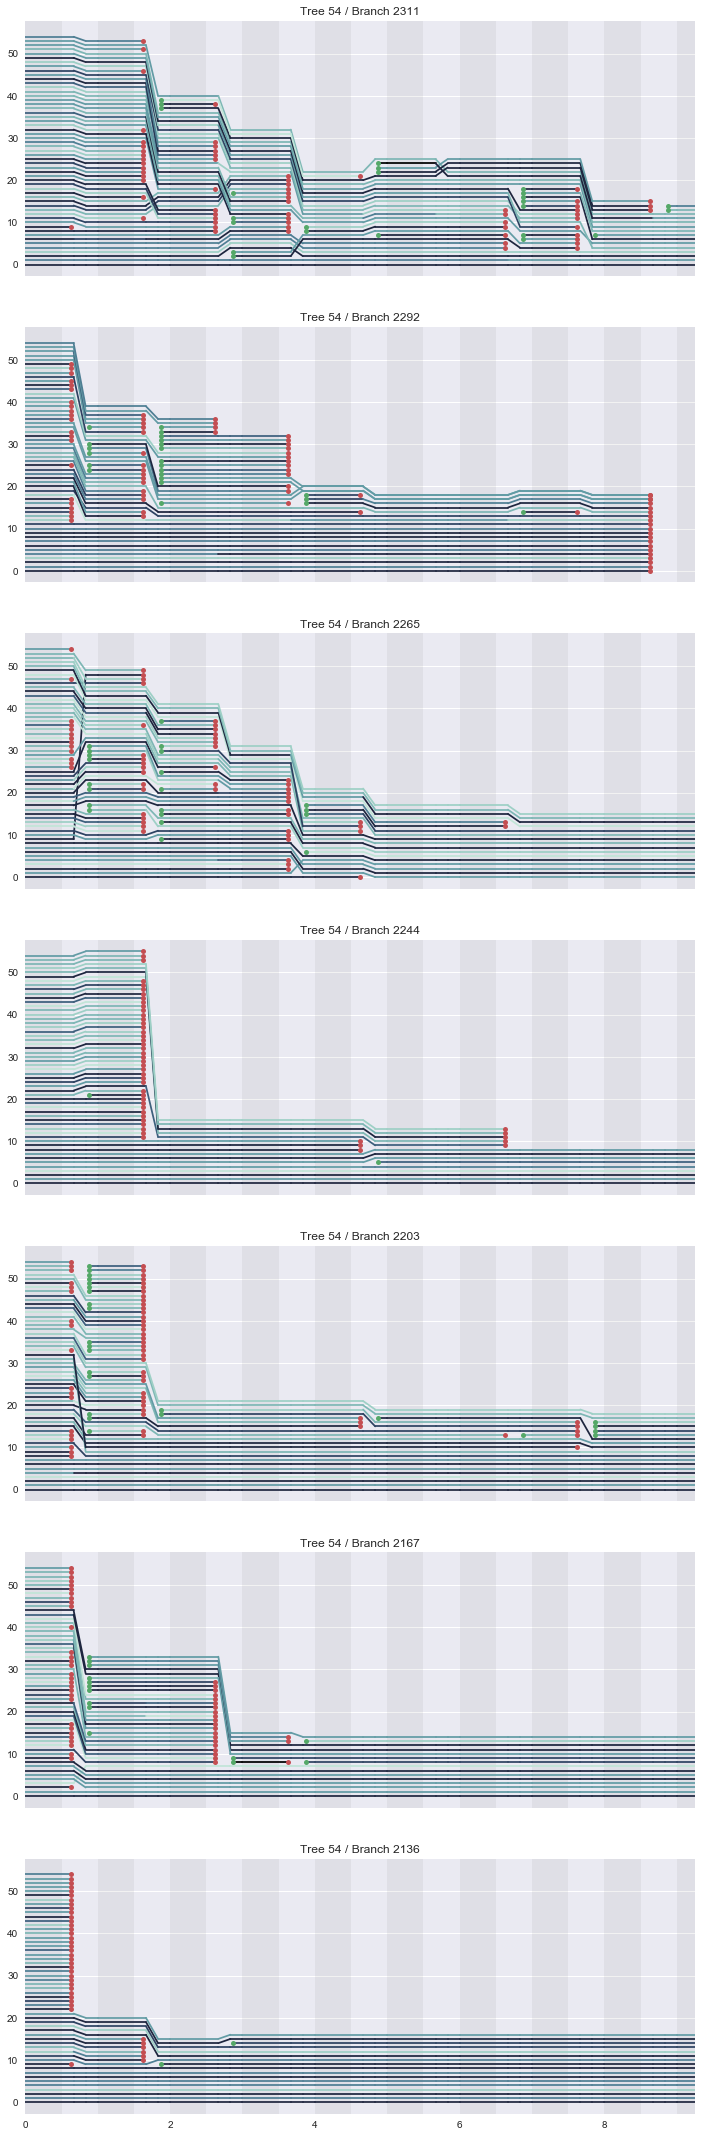

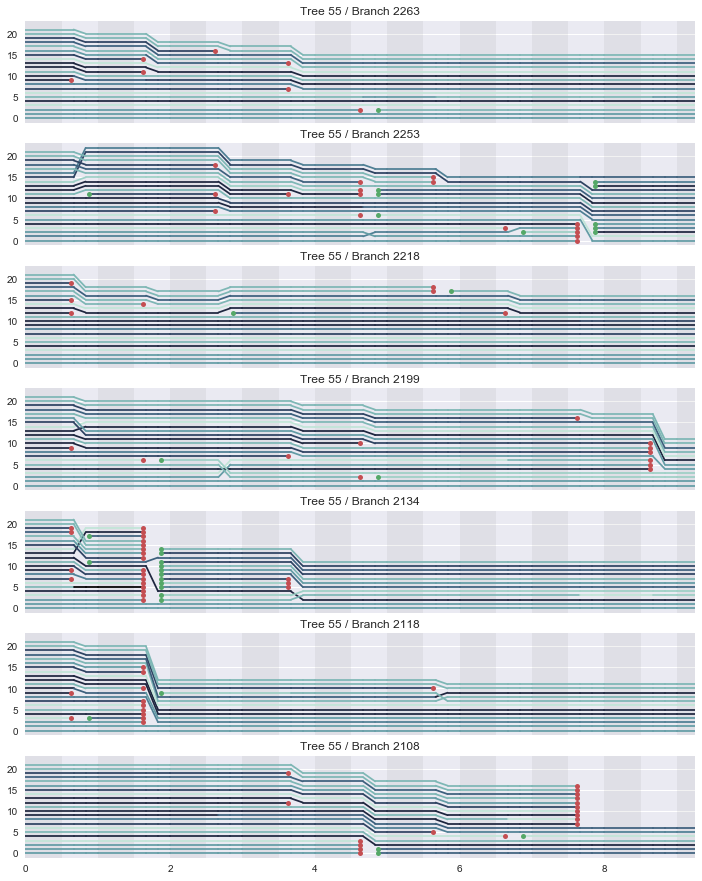

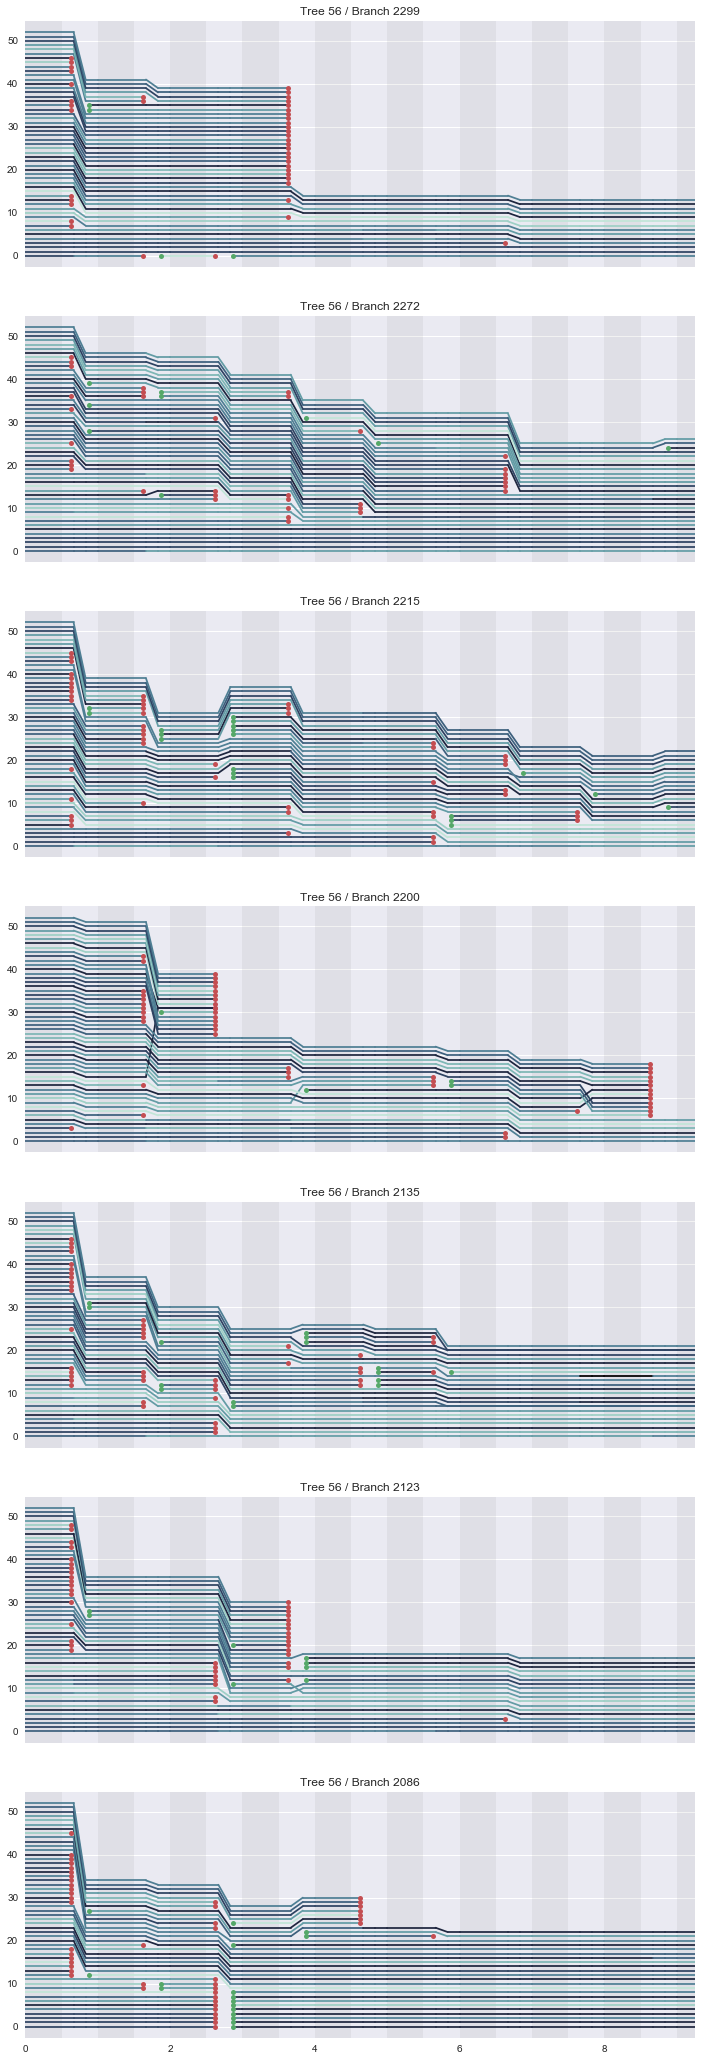

In [84]:
for tree_id in Tree.objects.experiment.values_list('id', flat=True):
    analysis.utils.Memoize.drop_caches()
    plot_tree(tree_id)